In [1]:
'''
figure plot of seasonality in the aerosol effect
author: You-Ting Wu @ NTUAS, Jun. 22, 2023
'''
from ast import mod
from fileinput import filename
import re
from turtle import title
import numpy as np
import xarray as xr
import math as m
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns
import imageio
import glob
from scipy.stats import norm
import statsmodels.api as sm

In [2]:
# initial data setting
lat_arctic = 70
lat_tropics = [-90,90]
year_interval = [[1955,1984],[1985, 2005], [1955, 2005]]
year_interval_str = ['1955','1985','2005']
exp_list = ['hist-aer', 'hist-GHG']
exp_list_cesm = ['AER','CO2']
model_list = ['CNRM-CM6-1','CanESM5','IPSL-CM6A-LR','MIROC6']
obs_list = ['HadCRUT5','GISTEMP','BEST']
month_abbr = ['Jan.','Feb.','Mar.','Apr.','May.','Jun.','Jul.','Aug.','Sep.','Oct.','Nov.','Dec.']
start_month = 6
month_abbr_shift = month_abbr[start_month-1:] + month_abbr[0:start_month-1]
alph = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)',]
blue = sns.color_palette("Blues", 15)
red = sns.color_palette("Reds", 15)
color_aer = [blue[4], blue[11], blue[-1]]
color_ghg = [red[4], red[11], red[-1]]

In [3]:
################################################## fx. ##################################################

def linear_trend(data, year_interval):
    
    data_trend = data.sel(year=slice(year_interval[0],year_interval[1])).polyfit(dim = 'year', deg = 1)['polyfit_coefficients'][0]

    return(data_trend)

def merge_data_cesm1fix1920(case, var):
    if var == 'alb':
        file_fsds = sorted(glob.glob(case+'/'+'FSDS'+'*.nc'))
        file_fsns = sorted(glob.glob(case+'/'+'FSNS'+'*.nc'))

        data_ALL_fsds = xr.open_dataarray(file_fsds[0])
        data_ALL_fsns = xr.open_dataarray(file_fsns[0])
        data_ALL_alb_mean = ((1 - data_ALL_fsns / data_ALL_fsds) * 100).mean('ensemble')

        data_tmp = []
        for i in range(1, len(file_fsds)):
            data_fsds = xr.open_dataarray(file_fsds[i])
            data_fsns = xr.open_dataarray(file_fsns[i])
            data_alb = ((1 - data_fsns / data_fsds) * 100)
            data_alb_mean = ((1 - data_fsns / data_fsds) * 100).mean('ensemble')
            data_tmp.append(data_alb - 2* data_alb_mean + data_ALL_alb_mean)

    else:
        file_all = sorted(glob.glob(case+'/'+var+'*.nc'))
        data_ALL = xr.open_dataarray(file_all[0])
        data_ALL_mean = data_ALL.mean('ensemble')

        data_tmp = []
        for i in range(1, len(file_all)):
            data = xr.open_dataarray(file_all[i])
            data_mean = data.mean('ensemble')
            data_tmp.append(data - 2* data_mean + data_ALL_mean)

    data_2agent = xr.concat(data_tmp, pd.Index(['AER','GHG'], name='agent')).transpose('ensemble',...)
    # ('ensemble', 'agent', 'area', 'year', 'month')

    return(data_2agent)

def temp_anomaly(data, name, year_ref):

    data_tmp = data.mean('month')

    # if name != 'obs':
    data_anom = data_tmp - data_tmp.sel(year=slice(year_ref[0], year_ref[1])).mean('year')
    # else:
        # data_anom = data_tmp.copy()

    if name == 'cesm1_fix1955' or name == 'canesm5_fix1955':
        data_anom = xr.concat([(data_anom.loc[:,'ALL'] - data_anom.loc[:,'xAER']), (data_anom.loc[:,'ALL'] - data_anom.loc[:,'xC2'])], pd.Index(['AER', 'CO2'], name='agent')).transpose('ensemble', 'agent',...)


    return(data_anom)

def agent_linear_trend(data, year_interval, area, month, **kwargs):

    if 'cesm1920' in kwargs:
        # get ALL, xAER, and xC2 data
        data_aer = data.sel(area = area, agent = 'AER')
        data_co2 = data.sel(area = area, agent = 'GHG')
        agent_coor = ['AER','CO2']
        year_interval_str = ['1955','1985','2005']
    elif 'damip' in kwargs:
        data_aer = data.sel(area = area, agent = 'hist-aer')
        data_co2 = data.sel(area = area, agent = 'hist-GHG')
        agent_coor = exp_list
        year_interval = [[1950,1980],[1955,1984],[1985, 2005], [1955, 2005]]
        year_interval_str = ['1940','1955','1985','2005']
    else:
        # get ALl, xAER, and xC2 data
        data_co2 = (data.sel(agent='ALL') - data.sel(agent='xC2')).sel(area = area)
        data_aer = (data.sel(agent='ALL') - data.sel(agent='xAER')).sel(area = area)
        agent_coor = ['AER','CO2']
        year_interval_str = ['1955','1985','2005']


    if month == 'none':
        data_aer_trend = xr.concat([linear_trend(data_aer, year_interval[i]) for i in range(len(year_interval))],\
                            pd.Index(year_interval_str, name='period'))
        data_co2_trend = xr.concat([linear_trend(data_co2, year_interval[i]) for i in range(len(year_interval))],\
                            pd.Index(year_interval_str, name='period'))
    else:
        str_annual = 'JFMAMJJASOND'
        idx = (str_annual*2).find(month)
        m = [np.mod(idx+i,12)+1 for i in range(len(month))]
        data_aer_trend = xr.concat([linear_trend(data_aer.sel(month = m).mean('month'), year_interval[i]) for i in range(len(year_interval))],\
                            pd.Index(year_interval_str, name='period'))
        data_co2_trend = xr.concat([linear_trend(data_co2.sel(month = m).mean('month'), year_interval[i]) for i in range(len(year_interval))],\
                            pd.Index(year_interval_str, name='period'))
        
    
    data_trend = xr.concat([data_aer_trend, data_co2_trend], pd.Index(agent_coor, name='agent'))

    if month != 'none':
        if month == str_annual:
            data_trend.attrs['season'] = 'annual'
        else:
            data_trend.attrs['season'] = month


    return(data_trend.transpose('ensemble', 'period',...))

def resampling_ratio_DAMIP(var, dts):

    random = np.array(np.random.choice(dts[0]['ensemble'].size, [N,dts[0]['ensemble'].size]), dtype=np.intp)

    # do resampling for given variable and ts
    var_rsp = [var[i].values[random,...].mean(1) for i in range(4)]
    ts_rsp =  [dts[i].values[random,...].mean(1) for i in range(4)]

    if len(var[0].dims) == 4:
        index = ["model", "rsp", "period", "agent", "month"]
        coords = {
            "model": model_list,
            "rsp": np.arange(N),
            "period": ['1940','1955','1985','2005'],
            "agent": dts[0]['agent'].values, 
            "month": dts[0]['month'].values
        }
    elif len(var[0].dims) == 3:
        index = ["model", "rsp", "period", "agent"]
        coords = {
            "model": model_list,
            "rsp": np.arange(N),
            "period": ['1940','1955','1985','2005'],
            "agent": dts[0]['agent'].values, 
        }
    
    # create dataset
    ds = xr.Dataset(
        {
            "variable": (index, var_rsp),
            "tas_global": (index, ts_rsp),
        },
        coords = coords
    )

    return(ds)

def resampling_ratio(var, dts, **kwargs):
    
    random = np.array(np.random.choice(dts['ensemble'].size, [N,dts['ensemble'].size]), dtype=np.intp)

    # do resampling for given variable and ts
    if 'cesm1955' in kwargs:
        random_co2 = np.array(np.random.choice(dts[:10]['ensemble'].size, [N,dts[:10]['ensemble'].size]), dtype=np.intp)
        var_rsp_co2 = var.sel(agent = 'CO2').values[random_co2,...].mean(1)
        ts_rsp_co2 =  dts.sel(agent = 'CO2').values[random_co2,...].mean(1)
        var_rsp_aer = var.sel(agent = 'AER').values[random,...].mean(1)
        ts_rsp_aer =  dts.sel(agent = 'AER').values[random,...].mean(1)
        var_rsp = np.concatenate((var_rsp_aer[:,:,np.newaxis], var_rsp_co2[:,:,np.newaxis]), axis = 2)
        ts_rsp = np.concatenate((ts_rsp_aer[:,:,np.newaxis], ts_rsp_co2[:,:,np.newaxis]), axis = 2)
    else:
        var_rsp = var.values[random,...].mean(1)
        ts_rsp =  dts.values[random,...].mean(1)

    if len(var.dims) == 4:
        index = ["rsp", "period", "agent", "month"]
        coords = {
            "rsp": np.arange(N),
            "period": year_interval_str,
            "agent": dts[0]['agent'].values, 
            "month": dts[0]['month'].values
        }
    elif len(var.dims) == 3:
        index = ["rsp", "period", "agent"]
        coords = {
            "rsp": np.arange(N),
            "period": year_interval_str,
            "agent": dts[0]['agent'].values, 
        }
    
    # create dataset
    ds = xr.Dataset(
        {
            "variable": (index, var_rsp),
            "tas_global": (index, ts_rsp),
        },
        coords = coords
    )

    return(ds)


In [4]:
################################## read files ##################################
#---------------------------------- Obs. ----------------------------------#
ts_obs = [xr.open_dataarray('obs/%s.nc'%(obs_list[i])) for i in range(len(obs_list))]


#---------------------------------- DAMIP ----------------------------------#
# case = 'damip_60N_masked'
case = 'damip_70N_masked'
sia_damip = [ (xr.open_dataarray(case+'/sia/sia_damip_%s.nc'%(model_list[i]))).transpose('ensemble',...) / 1e12 for i in range(len(model_list)) ]
tas_damip = [ xr.open_dataarray(case+'/tas/tas_damip_%s.nc'%(model_list[i])).transpose('ensemble',...) for i in range(len(model_list)) ]
rsds = [ xr.open_dataarray(case+'/rsds/rsds_damip_%s.nc'%(model_list[i])).transpose('ensemble',...) for i in range(len(model_list)) ]
rsus = [ xr.open_dataarray(case+'/rsus/rsus_damip_%s.nc'%(model_list[i])).transpose('ensemble',...) for i in range(len(model_list)) ]
alb_damip = [(rsus[i]/rsds[i])*100 for i in range(4)]
hfss = [ xr.open_dataarray(case+'/hfss/hfss_damip_%s.nc'%(model_list[i])).transpose('ensemble',...) for i in range(len(model_list)) ]
hfls = [ xr.open_dataarray(case+'/hfls/hfls_damip_%s.nc'%(model_list[i])).transpose('ensemble',...) for i in range(len(model_list)) ]
thf_damip = [hfss[i]+hfls[i] for i in range(4)]


#---------------------------------- CESM1-fix1955 ----------------------------------#
# case = 'cesm1_fix1955_60N_masked'
case = 'cesm1_fix1955_70N_masked'
ts_cesm1955 = xr.open_dataarray(case+'/TS_cesm1_fix1955.nc').transpose('ensemble',...)
sia_cesm1955 = xr.open_dataarray(case+'/ICEFRAC_cesm1_fix1955.nc').transpose('ensemble',...) / 1e12
fsns = xr.open_dataarray(case+'/FSNS_cesm1_fix1955.nc').transpose('ensemble',...) # downwelling shortwave flux at surface
fsds = xr.open_dataarray(case+'/FSDS_cesm1_fix1955.nc').transpose('ensemble',...)
lhflx = xr.open_dataarray(case+'/LHFLX_cesm1_fix1955.nc').transpose('ensemble',...) 
shflx = xr.open_dataarray(case+'/SHFLX_cesm1_fix1955.nc').transpose('ensemble',...)

thf_cesm1955 = (lhflx + shflx)
alb_cesm1955 = (1 - fsns / fsds) * 100 # albedo (%)


#---------------------------------- CanESM5-fix1955 ----------------------------------#
# case = 'canesm5_fix1955_60N_masked'
case = 'canesm5_fix1955_70N_masked'
ts_can1955 = xr.open_dataarray(case+'/tas_canesm5_fix1955.nc').transpose('ensemble',...)
sia_can1955 = xr.open_dataarray(case+'/siconc_canesm5_fix1955.nc').transpose('ensemble',...) / 1e12
rsds = xr.open_dataarray(case+'/rsds_canesm5_fix1955.nc').transpose('ensemble',...)
rsus = xr.open_dataarray(case+'/rsus_canesm5_fix1955.nc').transpose('ensemble',...)
hfss = xr.open_dataarray(case+'/hfss_canesm5_fix1955.nc').transpose('ensemble',...) 
hfls = xr.open_dataarray(case+'/hfls_canesm5_fix1955.nc').transpose('ensemble',...)

thf_can1955 = (hfss + hfls) # net surface heat flux (positive upward)
alb_can1955 = (rsus / rsds) * 100 # albedo (%)


#---------------------------------- CESM1-fix1920 ----------------------------------#
# case = 'cesm1_fix1920_60N_masked'
case = 'cesm1_fix1920_70N_masked'
ts_cesm1920 = merge_data_cesm1fix1920(case, 'TREFHT')
sia_cesm1920 = merge_data_cesm1fix1920(case, 'ICEFRAC') / 1e12
hfss = merge_data_cesm1fix1920(case, 'SHFLX') # sensible heat flux
hfls = merge_data_cesm1fix1920(case, 'LHFLX') # latent heat flux

thf_cesm1920 = (hfss + hfls) # net surface heat flux (positive upward)
alb_cesm1920 = merge_data_cesm1fix1920(case, 'alb')

In [5]:
tas_hist_damip = [ xr.open_dataarray('damip_70N_masked'+'/tas_historical/tas_historical_%s.nc'%(model_list[i])).transpose('ensemble',...) for i in range(len(model_list)) ]
tas_hist_cesm = xr.open_dataarray('cesm1_fix1920_70N_masked/TREFHT_ALL_cesm1_fix1920.nc').transpose('ensemble',...)

In [6]:

tsr_cesm1955 = temp_anomaly(ts_cesm1955, 'cesm1_fix1955', year_ref=[1955,1964])
tsr_can1955 = temp_anomaly(ts_can1955, 'canesm5_fix1955', year_ref=[1955,1964])
tsr_cesm1920 = temp_anomaly(ts_cesm1920, 'cesm1_fix1920', year_ref=[1920,1920])
tsr_damip = [temp_anomaly(tas_damip[i], 'damip', year_ref=[1920,1920]) for i in range(4)]
tsr_damip_hist = [temp_anomaly(tas_hist_damip[i], 'damip', year_ref=[1920,1920]) for i in range(4)]
tsr_cesm_hist = temp_anomaly(tas_hist_cesm, 'cesm1', year_ref=[1920,1920])
tsr_obs = [temp_anomaly(ts_obs[i], 'obs', year_ref=[1920,1920]) for i in range(3)]

In [7]:
################################## calculate trends for all months ##################################

#---------------------------------- DAMIP ----------------------------------#
sia_month_damip = [agent_linear_trend(sia_damip[j], year_interval, 'arctic', month='none', damip=True) for j in range(4)]
alb_month_damip = [agent_linear_trend(alb_damip[j], year_interval, 'arctic', month='none', damip=True) for j in range(4)]
thf_month_damip = [agent_linear_trend(thf_damip[j], year_interval, 'arctic', month='none', damip=True) for j in range(4)]
ta_month_damip = [agent_linear_trend(tas_damip[j], year_interval, 'arctic', month='none', damip=True) for j in range(4)]
tg_month_damip = [agent_linear_trend(tas_damip[j], year_interval, 'tropics', month='none', damip=True) for j in range(4)]


#---------------------------------- CESM1-fix1955 ----------------------------------#
sia_month_cesm1955 = agent_linear_trend(sia_cesm1955, year_interval, 'arctic', month='none')
alb_month_cesm1955 = agent_linear_trend(alb_cesm1955, year_interval, 'arctic', month='none')
thf_month_cesm1955 = agent_linear_trend(thf_cesm1955, year_interval, 'arctic', month='none')
ta_month_cesm1955 = agent_linear_trend(ts_cesm1955, year_interval, 'arctic', month='none')
tg_month_cesm1955 = agent_linear_trend(ts_cesm1955, year_interval, 'tropics', month='none')


#---------------------------------- CanESM5-fix1955 ----------------------------------#
sia_month_can1955 = agent_linear_trend(sia_can1955, year_interval, 'arctic', month='none')
alb_month_can1955 = agent_linear_trend(alb_can1955, year_interval, 'arctic', month='none')
thf_month_can1955 = agent_linear_trend(thf_can1955, year_interval, 'arctic', month='none')
ta_month_can1955 = agent_linear_trend(ts_can1955, year_interval, 'arctic', month='none')
tg_month_can1955 = agent_linear_trend(ts_can1955, year_interval, 'tropics', month='none')


#---------------------------------- CESM1-fix1920 ----------------------------------#
sia_month_cesm1920 = agent_linear_trend(sia_cesm1920, year_interval, 'arctic', month='none', cesm1920=True)
alb_month_cesm1920 = agent_linear_trend(alb_cesm1920, year_interval, 'arctic', month='none', cesm1920=True)
thf_month_cesm1920 = agent_linear_trend(thf_cesm1920, year_interval, 'arctic', month='none', cesm1920=True)
ta_month_cesm1920 = agent_linear_trend(ts_cesm1920, year_interval, 'arctic', month='none', cesm1920=True)
tg_month_cesm1920 = agent_linear_trend(ts_cesm1920, year_interval, 'tropics', month='none', cesm1920=True)

In [8]:
################################## calculate trends for seasonal/annual means ##################################
warm = 'JAS'
cold = 'OND'
annual = 'JFMAMJJASOND'

#---------------------------------- DAMIP ----------------------------------#
ta_ann_damip = [agent_linear_trend(tas_damip[j], year_interval, 'arctic', month=annual, damip=True) for j in range(4)]
tg_ann_damip = [agent_linear_trend(tas_damip[j], year_interval, 'tropics', month=annual, damip=True) for j in range(4)]
tg_warm_damip = [agent_linear_trend(tas_damip[j], year_interval, 'tropics', month=warm, damip=True) for j in range(4)]
tg_cold_damip = [agent_linear_trend(tas_damip[j], year_interval, 'tropics', month=cold, damip=True) for j in range(4)]

sia_ann_damip = [agent_linear_trend(sia_damip[j], year_interval, 'arctic', month=annual, damip=True) for j in range(4)]
alb_warm_damip = [agent_linear_trend(alb_damip[j], year_interval, 'arctic', month=warm, damip=True) for j in range(4)]
thf_cold_damip = [agent_linear_trend(thf_damip[j], year_interval, 'arctic', month=cold, damip=True) for j in range(4)]


#---------------------------------- CESM1-fix1955 ----------------------------------#
ta_ann_cesm1955 = agent_linear_trend(ts_cesm1955, year_interval, 'arctic', month=annual)
tg_ann_cesm1955 = agent_linear_trend(ts_cesm1955, year_interval, 'tropics', month=annual)
tg_cold_cesm1955 = agent_linear_trend(ts_cesm1955, year_interval, 'tropics', month=cold)
tg_warm_cesm1955 = agent_linear_trend(ts_cesm1955, year_interval, 'tropics', month=warm)

sia_ann_cesm1955 = agent_linear_trend(sia_cesm1955, year_interval, 'arctic', month=annual)
thf_cold_cesm1955 = agent_linear_trend(thf_cesm1955, year_interval, 'arctic', month=cold)
alb_warm_cesm1955 = agent_linear_trend(alb_cesm1955, year_interval, 'arctic', month=warm)   


#---------------------------------- CanESM5-fix1955 ----------------------------------#
ta_ann_can1955 = agent_linear_trend(ts_can1955, year_interval, 'arctic', month=annual)
tg_ann_can1955 = agent_linear_trend(ts_can1955, year_interval, 'tropics', month=annual)
tg_cold_can1955 = agent_linear_trend(ts_can1955, year_interval, 'tropics', month=cold)
tg_warm_can1955 = agent_linear_trend(ts_can1955, year_interval, 'tropics', month=warm)

sia_ann_can1955 = agent_linear_trend(sia_can1955, year_interval, 'arctic', month=annual)
thf_cold_can1955 = agent_linear_trend(thf_can1955, year_interval, 'arctic', month=cold)
alb_warm_can1955 = agent_linear_trend(alb_can1955, year_interval, 'arctic', month=warm)  


#---------------------------------- CESM1-fix1920 ----------------------------------#
ta_ann_cesm1920 = agent_linear_trend(ts_cesm1920, year_interval, 'arctic', month=annual, cesm1920 = True)
tg_ann_cesm1920 = agent_linear_trend(ts_cesm1920, year_interval, 'tropics', month=annual, cesm1920 = True)
tg_cold_cesm1920 = agent_linear_trend(ts_cesm1920, year_interval, 'tropics', month=cold, cesm1920 = True)
tg_warm_cesm1920 = agent_linear_trend(ts_cesm1920, year_interval, 'tropics', month=warm, cesm1920 = True)

sia_ann_cesm1920 = agent_linear_trend(sia_cesm1920, year_interval, 'arctic', month=annual, cesm1920 = True)
thf_cold_cesm1920 = agent_linear_trend(thf_cesm1920, year_interval, 'arctic', month=cold, cesm1920 = True)
alb_warm_cesm1920 = agent_linear_trend(alb_cesm1920, year_interval, 'arctic', month=warm, cesm1920 = True)

In [9]:
################################## resampling ##################################
N = 10000

#---------------------------------- DAMIP ----------------------------------#
# {'model': 4, 'rsp': 10000, 'period': 2, 'agent': 2}
msia_damip = resampling_ratio_DAMIP(sia_month_damip, tg_month_damip)
malb_dmaip = resampling_ratio_DAMIP(alb_month_damip, tg_month_damip)
mthf_damip = resampling_ratio_DAMIP(thf_month_damip, tg_month_damip)
maaf_damip = resampling_ratio_DAMIP(ta_month_damip, tg_month_damip)

aaaf_damip = resampling_ratio_DAMIP(ta_ann_damip, tg_ann_damip)
asia_damip = resampling_ratio_DAMIP(sia_ann_damip, tg_ann_damip)
walb_damip = resampling_ratio_DAMIP(alb_warm_damip, tg_warm_damip)
cthf_dmaip = resampling_ratio_DAMIP(thf_cold_damip, tg_cold_damip)



#---------------------------------- CESM1-fix1955 ----------------------------------#
# {'rsp': 10000, 'period': 2, 'agent': 2}
msia_cesm1955 = resampling_ratio(sia_month_cesm1955, tg_month_cesm1955, cesm1955=True)
malb_cesm1955 = resampling_ratio(alb_month_cesm1955, tg_month_cesm1955, cesm1955=True)
mthf_cesm1955 = resampling_ratio(thf_month_cesm1955, tg_month_cesm1955, cesm1955=True)
maaf_cesm1955 = resampling_ratio(ta_month_cesm1955, tg_month_cesm1955, cesm1955=True)

aaaf_cesm1955 = resampling_ratio(ta_ann_cesm1955, tg_ann_cesm1955, cesm1955=True)
asia_cesm1955 = resampling_ratio(sia_ann_cesm1955, tg_ann_cesm1955, cesm1955=True)
walb_cesm1955 = resampling_ratio(alb_warm_cesm1955, tg_warm_cesm1955, cesm1955=True)
cthf_cesm1955 = resampling_ratio(thf_cold_cesm1955, tg_cold_cesm1955, cesm1955=True)


#---------------------------------- CanESM5-fix1955 ----------------------------------#
# {'rsp': 10000, 'period': 2, 'agent': 2}
msia_can1955 = resampling_ratio(sia_month_can1955, tg_month_can1955)
malb_can1955 = resampling_ratio(alb_month_can1955, tg_month_can1955)
mthf_can1955 = resampling_ratio(thf_month_can1955, tg_month_can1955)
maaf_can1955 = resampling_ratio(ta_month_can1955, tg_month_can1955)

aaaf_can1955 = resampling_ratio(ta_ann_can1955, tg_ann_can1955)
asia_can1955 = resampling_ratio(sia_ann_can1955, tg_ann_can1955)
walb_can1955 = resampling_ratio(alb_warm_can1955, tg_warm_can1955)
cthf_can1955 = resampling_ratio(thf_cold_can1955, tg_cold_can1955)


#---------------------------------- CESM1-fix1920 ----------------------------------#
# {'rsp': 10000, 'period': 2, 'agent': 2}
msia_cesm1920 = resampling_ratio(sia_month_cesm1920, tg_month_cesm1920)
malb_cesm1920 = resampling_ratio(alb_month_cesm1920, tg_month_cesm1920)
mthf_cesm1920 = resampling_ratio(thf_month_cesm1920, tg_month_cesm1920)
maaf_cesm1920 = resampling_ratio(ta_month_cesm1920, tg_month_cesm1920)

aaaf_cesm1920 = resampling_ratio(ta_ann_cesm1920, tg_ann_cesm1920)
asia_cesm1920 = resampling_ratio(sia_ann_cesm1920, tg_ann_cesm1920)
walb_cesm1920 = resampling_ratio(alb_warm_cesm1920, tg_warm_cesm1920)
cthf_cesm1920 = resampling_ratio(thf_cold_cesm1920, tg_cold_cesm1920)


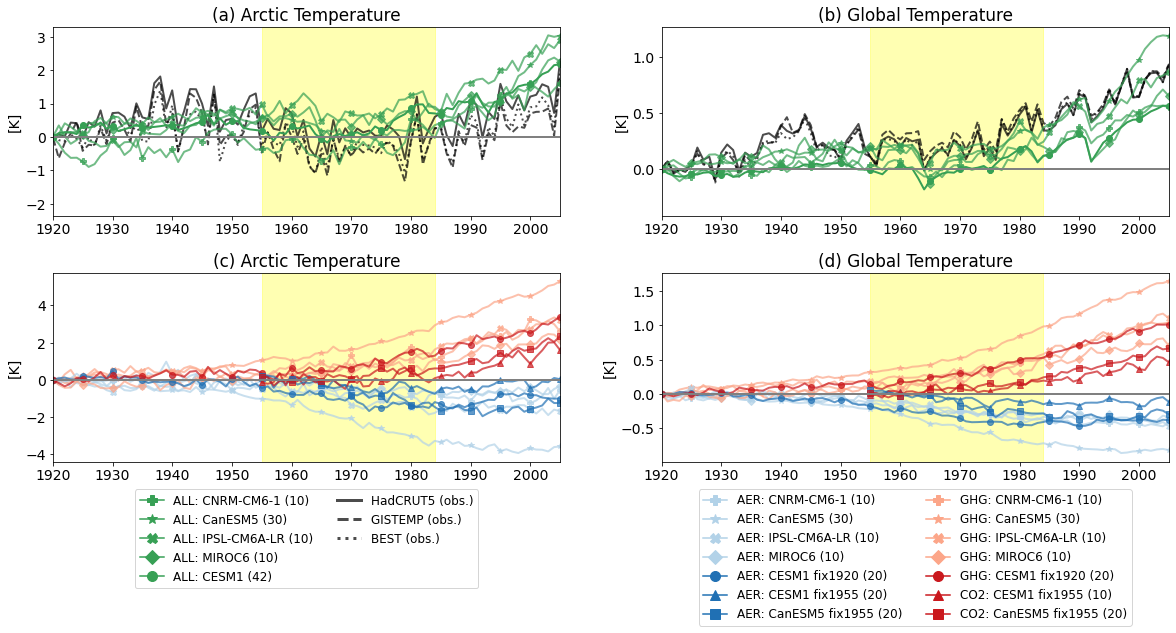

In [10]:
################################## figure 1 ##################################
# plot time series of TS in Arctic and global, respectively
green = sns.color_palette("Greens", 8)[5]
tsrc = [tsr_cesm1920, tsr_cesm1955, tsr_can1955]
fontsize = 14
ylim = [[-4, 4],[-1.5,1.5]]
color = [color_aer[0], color_ghg[0]]
colorc = [color_aer[1], color_ghg[1]]
color_diff = '#FFE171'
markers = ['P', '*', 'X', "D"]
markersc = ['o', '^', 's']
linestyle = ['solid', 'dashed','dotted']
num = [10,30,10,10]
numc = [20,10,20]
legend_name = [
        ['AER: CNRM-CM6-1', 'GHG: CNRM-CM6-1'],
        ['AER: CanESM5', 'GHG: CanESM5'],
        ['AER: IPSL-CM6A-LR', 'GHG: IPSL-CM6A-LR'],
        ['AER: MIROC6', 'GHG: MIROC6']
    ]
legend_namec = [
        ['AER: CESM1 fix1920', 'GHG: CESM1 fix1920'],
        ['AER: CESM1 fix1955', 'CO2: CESM1 fix1955'],
        ['AER: CanESM5 fix1955', 'CO2: CanESM5 fix1955']
    ]

title = ['(a) Arctic Temperature', '(b) Global Temperature','(c) Arctic Temperature', '(d) Global Temperature']


# plot
fig, ax = plt.subplots(2, 2, figsize=(20, 8))
plt.subplots_adjust(hspace = 0.3)

for i in range(2): # area

     # damip
    for j in range(4): # damip
        for k in range(2): # agent
            ax[1][i].plot(tsr_damip[j]['year'], tsr_damip[j].mean('ensemble').isel(area = i, agent = k), color=color[k], marker=markers[j], markersize=6, linewidth=2, markevery = 5, alpha = 0.7)

    # All-but exp.s
    for j in range(3):
        for k in range(2):
            ax[1][i].plot(tsrc[j]['year'].sel(year = slice(1900,2005)), tsrc[j].mean('ensemble').sel(year = slice(1900,2005)).isel(area = i, agent = k), color=colorc[k], marker=markersc[j], markersize=6, linewidth=2, markevery = 5, alpha = 0.7)

    # obs
    for j in range(3):
        ax[0][i].plot(tsr_obs[j]['year'].sel(year = slice(1900,2005)), tsr_obs[j].sel(year = slice(1900,2005)).isel(area = i), color = 'black', linestyle=linestyle[j], linewidth=2, alpha = 0.7, markevery = 5)

    # historical
    for j in range(4): # damip
        ax[0][i].plot(tsr_damip_hist[j]['year'], tsr_damip_hist[j].mean('ensemble').isel(area = i, agent = 0), color=green, marker=markers[j], markersize=6, linewidth=2, markevery = 5, alpha = 0.7)

    ax[0][i].plot(tsr_cesm_hist['year'], tsr_cesm_hist.mean('ensemble').isel(area = i), color=green, marker='o', markersize=6, linewidth=2, markevery = 5)

for i in range(len(ax.flatten())):
    # axis setting
    ax.flatten()[i].set_xlim(1920, 2005)
    ax.flatten()[i].set_xticks(np.arange(1920, 2006, 10))
    # ax[i].set_ylim(ylim[i])
    ax.flatten()[i].axhline(y=0, color='grey', linestyle='-', linewidth=2, alpha = 1)
    ax.flatten()[i].set_ylabel('[K]', fontsize=fontsize)
    ax.flatten()[i].tick_params(axis='both', which='major', labelsize=fontsize)
    ax.flatten()[i].set_title(title[i], fontsize=fontsize*1.2)
    ax.flatten()[i].axvspan(1955,1984, alpha=0.3, color='yellow')

# legend
legend = []
for i in range(2):
    for j in range(7):
        if j < 4:
            legend.append(mlines.Line2D([], [], color = color[i], marker = markers[j], markersize=10, label='%s (%s)'%(legend_name[j][i], num[j])))
        else:
            if i == 0 and j == 5:
                legend.append(mlines.Line2D([], [], color = colorc[i], marker = markersc[j-4], markersize=10, label='%s (%s)'%(legend_namec[j-4][i], 20)))
            else:
                legend.append(mlines.Line2D([], [], color = colorc[i], marker = markersc[j-4], markersize=10, label='%s (%s)'%(legend_namec[j-4][i], numc[j-4])))

ax[1][1].legend(handles = legend,loc='lower center', bbox_to_anchor=(0.5, -0.9), fontsize = fontsize-2, ncol = 2)

ll = ['ALL: CNRM-CM6-1', 'ALL: CanESM5', 'ALL: IPSL-CM6A-LR', 'ALL: MIROC6', 'ALL: CESM1']
n = [10,30,10,10,42]
m = ['P', '*', 'X', "D",'o']
legend_upper = []
for i in range(5):
    legend_upper.append(mlines.Line2D([], [], color = green, marker = m[i], markersize=10, label='%s (%s)'%(ll[i], n[i])))
for i in range(3):
    legend_upper.append(mlines.Line2D([], [], color = 'black', linestyle = linestyle[i], linewidth=3, alpha = 0.7, label='%s (obs.)'%(obs_list[i])))
legend_upper.append(mlines.Line2D([], [], color = 'white', label=''))
legend_upper.append(mlines.Line2D([], [], color = 'white', label=''))

ax[1][0].legend(handles = legend_upper,loc='lower center', bbox_to_anchor=(0.5, -0.7), fontsize = fontsize-2, ncol = 2)


# white background plt
# plt.style.use("default")
plt.savefig('figure/fig1.jpg', format='jpg', dpi=300, transparent=False, bbox_inches='tight')

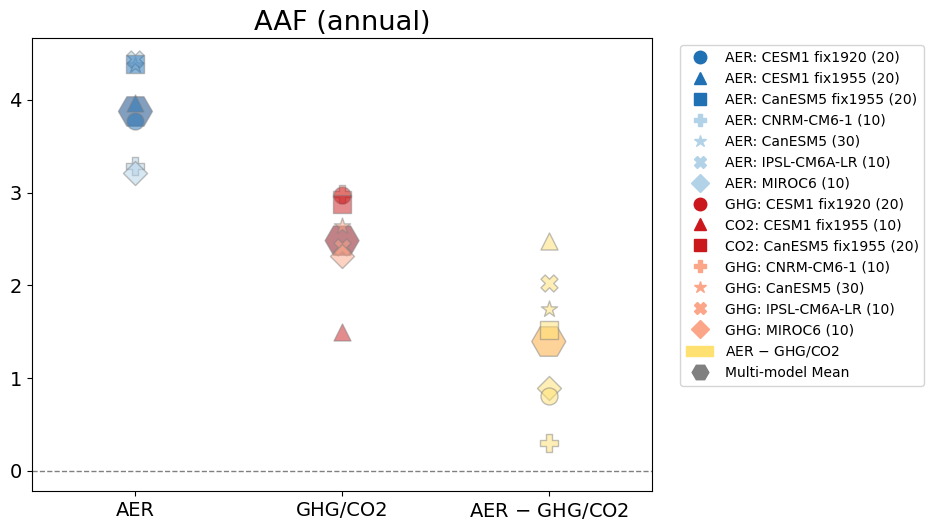

In [11]:
################################## figure 2 ##################################
# plot 3 panels of scatter plot, each panel is for one variables
variable = [aaaf_damip]
variablec = [[aaaf_cesm1920], [aaaf_cesm1955], [aaaf_can1955]]
variable_name = ['AAF (annual)']
variable_unit = ['']
variable_range = [[-0.5,0.5],[-0.5,0.5],[-0.5,0.5]]
fontsize = 14
color = [color_aer[0], color_ghg[0]]
colorc = [color_aer[1], color_ghg[1]]
color_mean = [color_aer[2], color_ghg[2], sns.color_palette("YlOrBr", 10)[4]]
color_diff = '#FFE171'
markers = ['P', '*', 'X', "D"]
markersc = ['o', '^', 's']
legend_name = [
        ['AER: CNRM-CM6-1', 'GHG: CNRM-CM6-1'],
        ['AER: CanESM5', 'GHG: CanESM5'],
        ['AER: IPSL-CM6A-LR', 'GHG: IPSL-CM6A-LR'],
        ['AER: MIROC6', 'GHG: MIROC6']
    ]
legend_namec = [
        ['AER: CESM1 fix1920', 'GHG: CESM1 fix1920'],
        ['AER: CESM1 fix1955', 'CO2: CESM1 fix1955'],
        ['AER: CanESM5 fix1955', 'CO2: CanESM5 fix1955']
    ]

# add legend outside the plot
num = [10,30,10,10]
numc = [20,10,20]
legend = []
for i in range(2):
    for j in range(3):
        if i ==0 and j == 1:
            legend.append(mlines.Line2D([], [], color = colorc[i], marker = markersc[j], markersize=9, label='%s (%s)'%(legend_namec[j][i], 20), linestyle = 'None'))
        else:
            legend.append(mlines.Line2D([], [], color = colorc[i], marker = markersc[j], markersize=9, label='%s (%s)'%(legend_namec[j][i], numc[j]), linestyle = 'None'))
    for j in range(4):
        legend.append(mlines.Line2D([], [], color = color[i], marker = markers[j], markersize=9, label='%s (%s)'%(legend_name[j][i], num[j]), linestyle = 'None'))
legend.append(mpatches.Patch(color= color_diff, label='AER $-$ GHG/CO2'))
legend.append(mlines.Line2D([], [], color = 'grey', marker = 'H', markersize=12, label='Multi-model Mean', linestyle = 'None'))

mean_aer = []
mean_ghg = []
fig = plt.figure(figsize=(8,6), dpi = 100)
for i in range(1):
    ax = fig.add_subplot(1,1,i+1)
    for j in range(7): # model
        if j <4:
            for k in range(2): # agent
                ax.scatter([k], (variable[i]['variable'].mean('rsp').sel(model = model_list[j], period = year_interval_str[0], agent = exp_list[k])/variable[i]['tas_global']).mean('rsp').sel(model = model_list[j], period = year_interval_str[0], agent = exp_list[k]),\
                        s = 150, color = color[k], alpha = 0.5, marker = markers[j], edgecolor='grey')
                
            mean_aer.append((variable[i]['variable'].mean('rsp').sel(model = model_list[j], period = year_interval_str[0], agent = exp_list[0])/variable[i]['tas_global'].mean('rsp').sel(model = model_list[j], period = year_interval_str[0], agent = exp_list[0])).values)
            mean_ghg.append((variable[i]['variable'].mean('rsp').sel(model = model_list[j], period = year_interval_str[0], agent = exp_list[1])/variable[i]['tas_global'].mean('rsp').sel(model = model_list[j], period = year_interval_str[0], agent = exp_list[1])).values)
        
                                                       

            diff = (variable[i]['variable'].mean('rsp').sel(model = model_list[j], period = year_interval_str[0], agent = exp_list[0])/variable[i]['tas_global']).mean('rsp').sel(model = model_list[j], period = year_interval_str[0], agent = exp_list[0]) - \
                    (variable[i]['variable'].mean('rsp').sel(model = model_list[j], period = year_interval_str[0], agent = exp_list[1])/variable[i]['tas_global']).mean('rsp').sel(model = model_list[j], period = year_interval_str[0], agent = exp_list[1])
            
            ax.scatter([2], [diff], s = 150, color = color_diff, alpha = 0.5, marker = markers[j], edgecolor='grey')

        else:
            for k in range(2): # agent
                ax.scatter([k], (variablec[j-4][i]['variable'].mean('rsp').sel(period = year_interval_str[0], agent = exp_list_cesm[k])/variablec[j-4][i]['tas_global']).mean('rsp').sel(period = year_interval_str[0], agent = exp_list_cesm[k]),\
                        s = 150, color = colorc[k], alpha = 0.5, marker = markersc[j-4], edgecolor='grey')
            
            mean_aer.append((variablec[j-4][i]['variable'].mean('rsp').sel(period = year_interval_str[0], agent = exp_list_cesm[0])/variablec[j-4][i]['tas_global'].mean('rsp').sel(period = year_interval_str[0], agent = exp_list_cesm[0])).values)
            mean_ghg.append((variablec[j-4][i]['variable'].mean('rsp').sel(period = year_interval_str[0], agent = exp_list_cesm[1])/variablec[j-4][i]['tas_global'].mean('rsp').sel(period = year_interval_str[0], agent = exp_list_cesm[1])).values)
                
                
            diff = (variablec[j-4][i]['variable'].mean('rsp').sel(period = year_interval_str[0], agent = exp_list_cesm[0])/variablec[j-4][i]['tas_global']).mean('rsp').sel(period = year_interval_str[0], agent = exp_list_cesm[0]) - \
                    (variablec[j-4][i]['variable'].mean('rsp').sel(period = year_interval_str[0], agent = exp_list_cesm[1])/variablec[j-4][i]['tas_global']).mean('rsp').sel(period = year_interval_str[0], agent = exp_list_cesm[1])
            ax.scatter([2], [diff], s = 150, color = color_diff, alpha = 0.5, marker = markersc[j-4], edgecolor='grey')

    # add mean
    ax.scatter([0,1,2], [np.mean(mean_aer), np.mean(mean_ghg), np.mean(mean_aer)-np.mean(mean_ghg)], s = 600, color = color_mean, alpha = 0.5, marker = 'H', edgecolor='grey', linewidths=1, zorder = -100)


    # axis setting
    ax.set_xlim([-0.5,2.5])
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(['AER', 'GHG/CO2','AER $-$ GHG/CO2'], fontsize = fontsize)
    ax.set_ylabel(variable_unit[i], fontsize = fontsize)
    ax.set_title(variable_name[i], fontsize = fontsize*1.4)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    # add horizontal line
    ax.axhline(y=0, color='grey', linestyle='--', linewidth = 1)
    # ax.set_ylim([1.4,5.])

    ax.legend(handles = legend,loc='upper right',fontsize = fontsize-4, bbox_to_anchor=(1.45, 1.0), ncol=1)
plt.savefig('figure/fig2.jpg', format='jpg', dpi=300, transparent=False, bbox_inches='tight')




In [12]:
np.mean(mean_aer)
np.mean(mean_ghg)

2.480988197306374

/Users/youtingw/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/youtingw/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/youtingw/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-leve

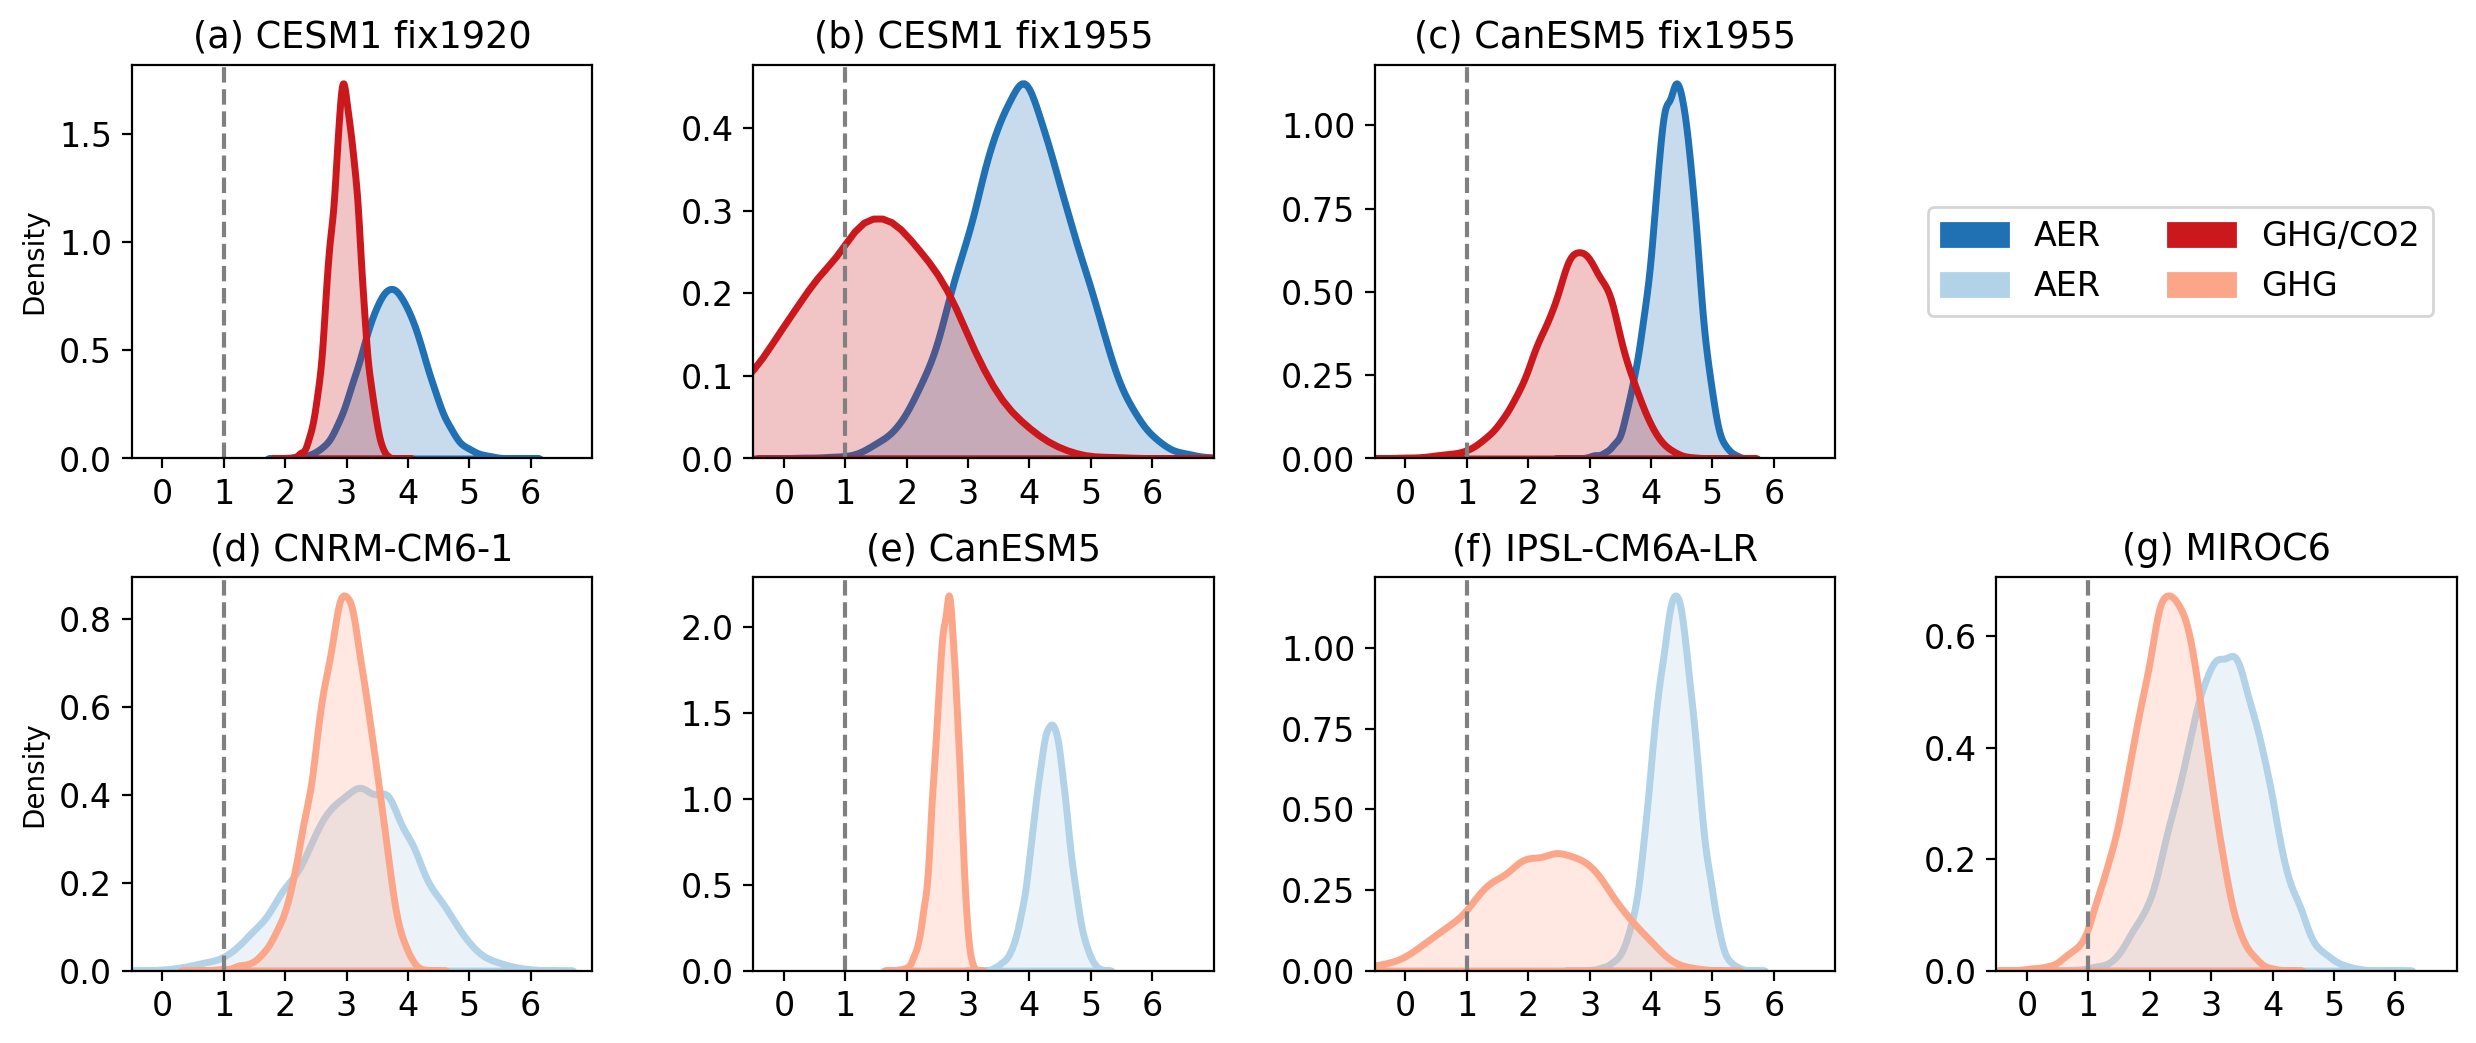

In [13]:
################################## figure 3 ##################################
# calculate resampled AAF
raaf_damip = aaaf_damip['variable'] / aaaf_damip['tas_global']
raaf_cesm1955 = aaaf_cesm1955['variable'] / aaaf_cesm1955['tas_global']
raaf_can1955 = aaaf_can1955['variable'] / aaaf_can1955['tas_global']
raaf_cesm1920 = aaaf_cesm1920['variable'] / aaaf_cesm1920['tas_global']

aaf_plot = [raaf_cesm1920, raaf_cesm1955, raaf_can1955, raaf_damip]

fontsize = 12
xlim = [-0.5, 7]
color = [color_aer[0], color_ghg[0]]
colorc = [color_aer[1], color_ghg[1]]
markers = ['P', '*', 'X', "D"]
markersc = ['o', '^', 's']
num = [10,30,10,10]
numc = [20,10,20]
legend_name = [
        ['AER - CNRM-CM6-1', 'GHG - CNRM-CM6-1'],
        ['AER - CanESM5', 'GHG - CanESM5'],
        ['AER - IPSL-CM6A-LR', 'GHG - IPSL-CM6A-LR'],
        ['AER - MIROC6', 'GHG - MIROC6']
    ]
legend_namec = [
        ['AER - CESM1 fix1920', 'GHG - CESM1 fix1920'],
        ['AER - CESM1 fix1955', 'CO2 - CESM1 fix1955'],
        ['AER - CanESM5 fix1955', 'CO2 - CanESM5 fix1955']
    ]

color_name = [['AER','GHG/CO2'],['AER','GHG']]

# plot distribution using sns
fig, ax = plt.subplots(2, 4, figsize=(15, 6), dpi = 200)
fig.delaxes(ax[0, 3])

# more space between subplots
fig.subplots_adjust(hspace = 0.3, wspace=0.35)

for i in range(4):
    if i <3:
        for j in range(2): # agent
            sns.distplot(aaf_plot[i].sel(period = year_interval_str[0], agent = exp_list_cesm[j]), ax=ax[0, i], hist=False, kde=True, rug=False, kde_kws={"shade": True, 'linewidth': 2.5}, color=colorc[j])
        ax[0,i].set_title(alph[i] +' '+legend_namec[i][0].split(' - ')[1], fontsize=fontsize*1.1)

    else:
        for j in range(2): # agent
            for k in range(4):
                sns.distplot(aaf_plot[i][k].sel(period = year_interval_str[0], agent = exp_list[j]), ax=ax[1, k], hist=False, kde=True, rug=False, kde_kws={"shade": True, 'linewidth': 2.5}, color=color[j])

                ax[1,k].set_title(alph[i+k] +' '+legend_name[k][0].split(' - ')[1], fontsize=fontsize*1.1)


for i in range(len(ax.flatten())):
    ax.flatten()[i].set_xlim(xlim)
    ax.flatten()[i].set_xticks(np.arange(0, 6+0.5, 1))
    ax.flatten()[i].set_xticklabels(np.arange(0, 6+0.5, 1).astype(int), fontsize=fontsize)
    ax.flatten()[i].axvline(x = 1, color='grey', ls='--', lw=1.5)
    ax.flatten()[i].tick_params(axis='both', which='major', labelsize=fontsize)

    if np.mod(i,4) != 0:
        # close y-label
        ax.flatten()[i].set_ylabel('')

# add legend
legend = []
for j in range(2):
    legend.append(mpatches.Patch(color= colorc[j], label=color_name[0][j]))
    legend.append(mpatches.Patch(color= color[j], label=color_name[1][j]))


ax[0,2].legend(handles = legend,loc='center', bbox_to_anchor=(1.75, 0.5), fontsize = fontsize, ncol = 2)

plt.savefig('figure/fig3.jpg', format='jpg', dpi=300, transparent=False, bbox_inches='tight')


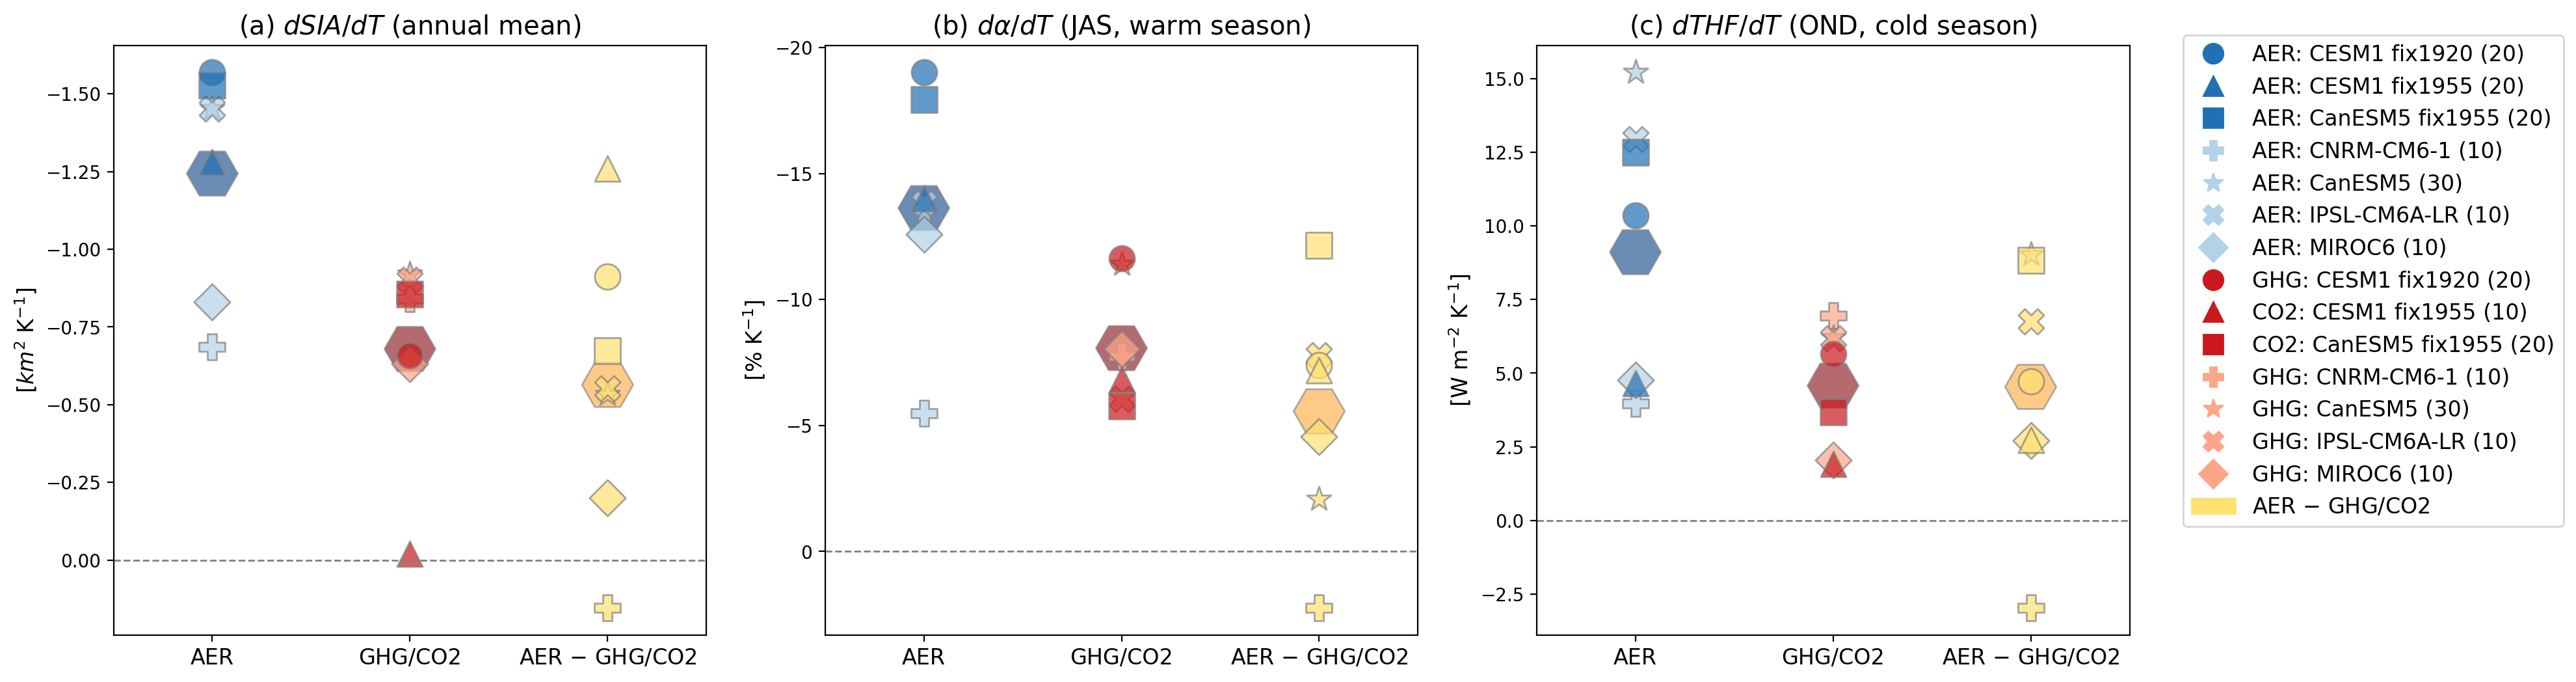

In [14]:
################################## figure 4 ##################################
# plot 3 panels of scatter plot, each panel is for one variables
variable = [asia_damip, walb_damip, cthf_dmaip]
variablec = [[asia_cesm1920, walb_cesm1920, cthf_cesm1920], [asia_cesm1955, walb_cesm1955, cthf_cesm1955], [asia_can1955, walb_can1955, cthf_can1955]]
variable_name = ['(a) $dSIA/dT$ (annual mean)',r'(b) $d\alpha/dT$'+' (%s, warm season)'%(warm),'(c) $dTHF/dT$ (%s, cold season)'%(cold)]
variable_unit = ['[$km^2$ K$^{-1}$]','[% K$^{-1}$]','[W m$^{-2}$ K$^{-1}$]']
fontsize = 12
color = [color_aer[0], color_ghg[0]]
colorc = [color_aer[1], color_ghg[1]]
color_diff = '#FFE171'
markers = ['P', '*', 'X', "D"]
markersc = ['o', '^', 's']
legend_name = [
        ['AER: CNRM-CM6-1', 'GHG: CNRM-CM6-1'],
        ['AER: CanESM5', 'GHG: CanESM5'],
        ['AER: IPSL-CM6A-LR', 'GHG: IPSL-CM6A-LR'],
        ['AER: MIROC6', 'GHG: MIROC6']
    ]
legend_namec = [
        ['AER: CESM1 fix1920', 'GHG: CESM1 fix1920'],
        ['AER: CESM1 fix1955', 'CO2: CESM1 fix1955'],
        ['AER: CanESM5 fix1955', 'CO2: CanESM5 fix1955']
    ]

# add legend outside the plot
num = [10,30,10,10]
numc = [20,10,20]
legend = []
for i in range(2):
    for j in range(3):
        if i == 0 and j ==1:
            legend.append(mlines.Line2D([], [], color = colorc[i], marker = markersc[j], markersize=11, label='%s (%s)'%(legend_namec[j][i], 20), linestyle = 'None'))
        else:
            legend.append(mlines.Line2D([], [], color = colorc[i], marker = markersc[j], markersize=11, label='%s (%s)'%(legend_namec[j][i], numc[j]), linestyle = 'None'))
    for j in range(4):
        legend.append(mlines.Line2D([], [], color = color[i], marker = markers[j], markersize=11, label='%s (%s)'%(legend_name[j][i], num[j]), linestyle = 'None'))
legend.append(mpatches.Patch(color= color_diff, label='AER $-$ GHG/CO2'))


fig = plt.figure(figsize=(20,6), dpi = 200)
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    mean_aer = []
    mean_ghg = []
    for j in range(7): # model
        if j <4:
            for k in range(2): # agent
                ax.scatter([k], (variable[i]['variable'].mean('rsp').sel(model = model_list[j], period = year_interval_str[0], agent = exp_list[k])/variable[i]['tas_global']).mean('rsp').sel(model = model_list[j], period = year_interval_str[0], agent = exp_list[k]),\
                        s = 200, color = color[k], alpha = 0.7, marker = markers[j], edgecolor='grey')
            
            diff = (variable[i]['variable'].mean('rsp').sel(model = model_list[j], period = year_interval_str[0], agent = exp_list[0])/variable[i]['tas_global']).mean('rsp').sel(model = model_list[j], period = year_interval_str[0], agent = exp_list[0]) - (variable[i]['variable'].mean('rsp').sel(model = model_list[j], period = year_interval_str[0], agent = exp_list[1])/variable[i]['tas_global']).mean('rsp').sel(model = model_list[j], period = year_interval_str[0], agent = exp_list[1])

            mean_aer.append((variable[i]['variable'].mean('rsp').sel(model = model_list[j], period = year_interval_str[0], agent = exp_list[0])/variable[i]['tas_global'].mean('rsp').sel(model = model_list[j], period = year_interval_str[0], agent = exp_list[0])).values)
            mean_ghg.append((variable[i]['variable'].mean('rsp').sel(model = model_list[j], period = year_interval_str[0], agent = exp_list[1])/variable[i]['tas_global'].mean('rsp').sel(model = model_list[j], period = year_interval_str[0], agent = exp_list[1])).values)

            ax.scatter([2], diff, s = 200, color = color_diff, alpha = 0.7, marker = markers[j], edgecolor='grey')

        else:
            for k in range(2): # agent
                ax.scatter([k], (variablec[j-4][i]['variable'].mean('rsp').sel(period = year_interval_str[0], agent = exp_list_cesm[k])/variablec[j-4][i]['tas_global']).mean('rsp').sel(period = year_interval_str[0], agent = exp_list_cesm[k]),\
                        s = 200, color = colorc[k], alpha = 0.7, marker = markersc[j-4], edgecolor='grey')
                
            diff = (variablec[j-4][i]['variable'].mean('rsp').sel(period = year_interval_str[0], agent = exp_list_cesm[0])/variablec[j-4][i]['tas_global']).mean('rsp').sel(period = year_interval_str[0], agent = exp_list_cesm[0]) - (variablec[j-4][i]['variable'].mean('rsp').sel(period = year_interval_str[0], agent = exp_list_cesm[1])/variablec[j-4][i]['tas_global']).mean('rsp').sel(period = year_interval_str[0], agent = exp_list_cesm[1])

            mean_aer.append((variablec[j-4][i]['variable'].mean('rsp').sel(period = year_interval_str[0], agent = exp_list_cesm[0])/variablec[j-4][i]['tas_global'].mean('rsp').sel(period = year_interval_str[0], agent = exp_list_cesm[0])).values)
            mean_ghg.append((variablec[j-4][i]['variable'].mean('rsp').sel(period = year_interval_str[0], agent = exp_list_cesm[1])/variablec[j-4][i]['tas_global'].mean('rsp').sel(period = year_interval_str[0], agent = exp_list_cesm[1])).values)
            
            ax.scatter([2], diff, s = 200, color = color_diff, alpha = 0.7, marker = markersc[j-4], edgecolor='grey')
    
    # add mean
    ax.scatter([0,1,2], [np.mean(mean_aer), np.mean(mean_ghg), np.mean(mean_aer)-np.mean(mean_ghg)], s = 800, color = color_mean, alpha = 0.6, marker = 'H', edgecolor='grey', linewidths=1, zorder = -100)


    # axis setting
    ax.set_xlim([-0.5,2.5])
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(['AER', 'GHG/CO2', 'AER $-$ GHG/CO2'], fontsize = fontsize)
    ax.axhline(y=0, color='grey', linestyle='--', linewidth = 1)
    ax.set_ylabel(variable_unit[i], fontsize = fontsize)
    ax.set_title(variable_name[i], fontsize = fontsize*1.2)
    # filp the y-axis
    if i == 0 or i==1:
        ax.invert_yaxis()
    else:
        ax.legend(handles = legend,loc='right', bbox_to_anchor=(1.75, 0.6), fontsize = fontsize)
    
plt.savefig('figure/fig4.jpg', format='jpg', dpi=300, transparent=False, bbox_inches='tight')


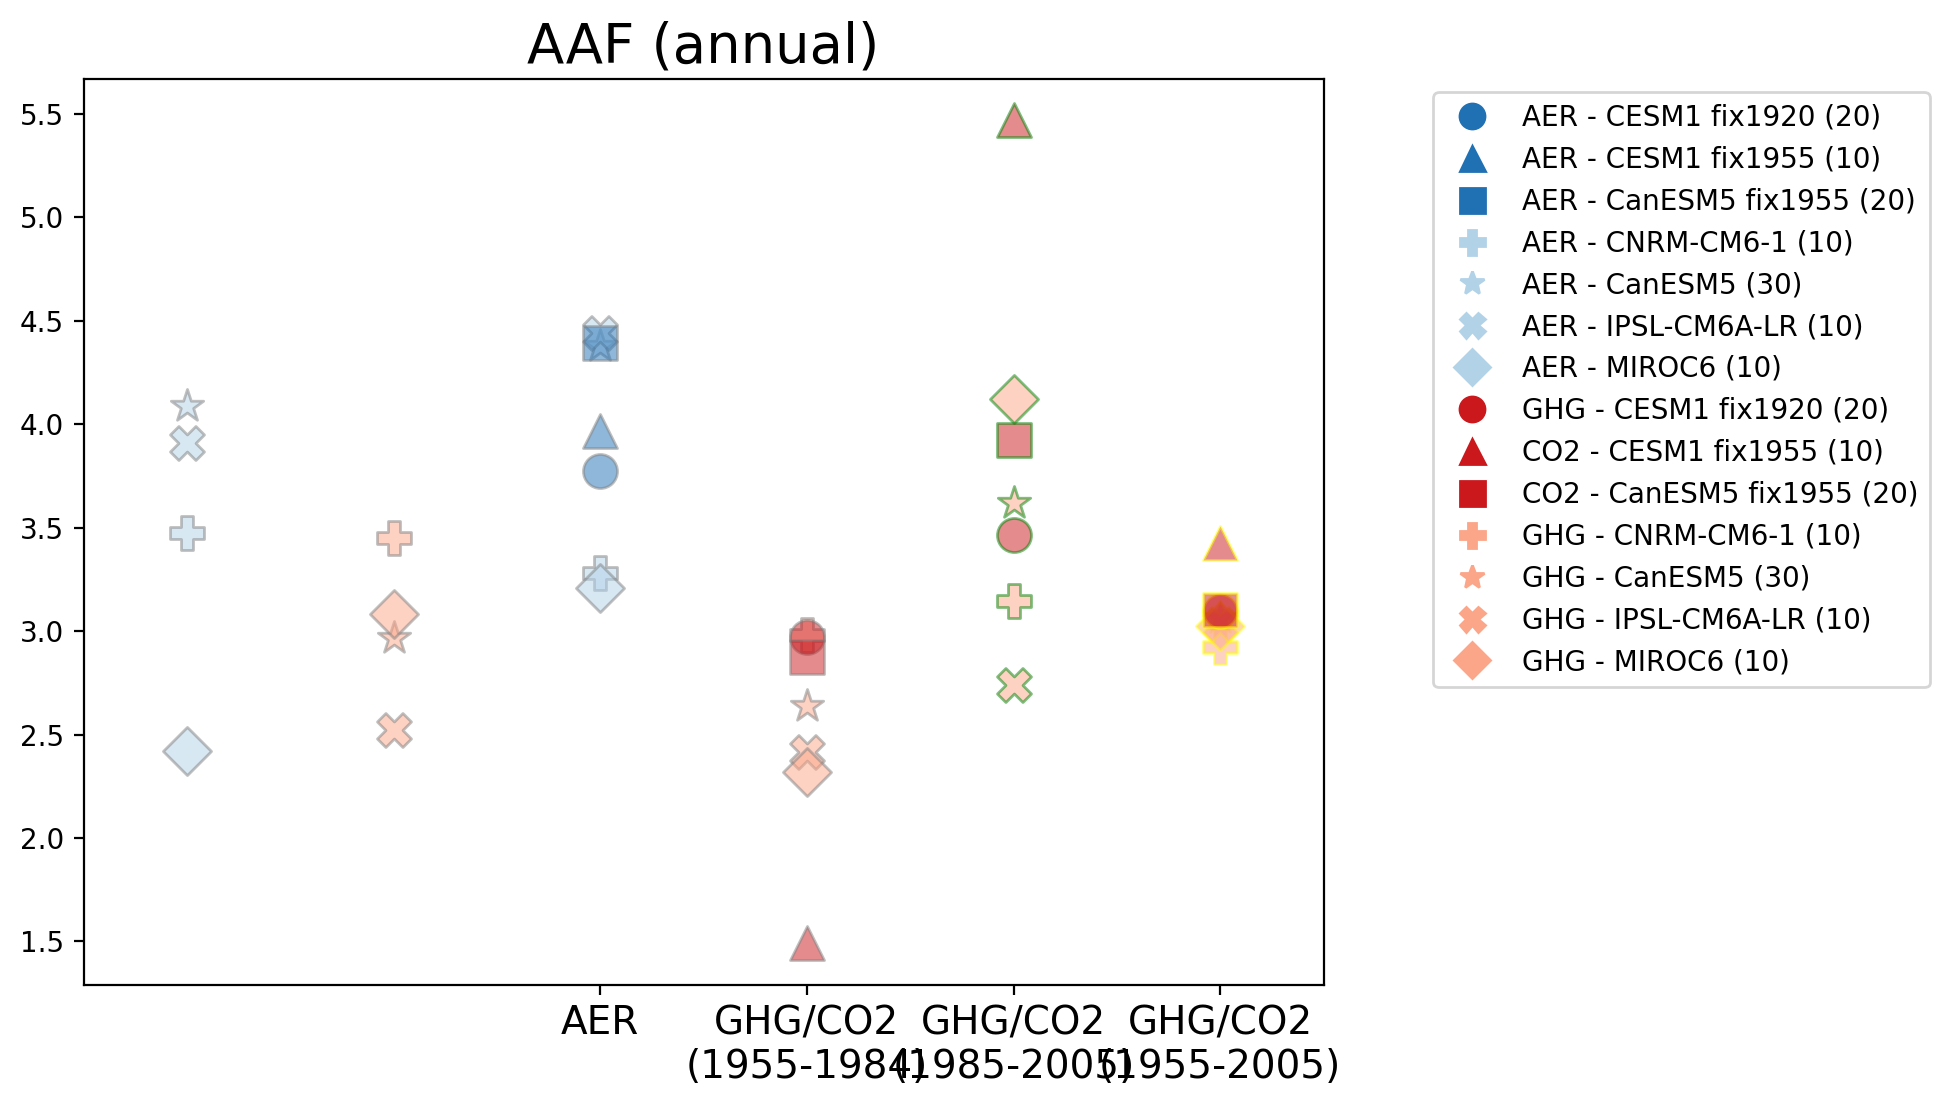

In [15]:
################################## figure 2 (supp.) ##################################
# plot 3 panels of scatter plot, each panel is for one variables
variable = [aaaf_damip]
variablec = [[aaaf_cesm1920], [aaaf_cesm1955], [aaaf_can1955]]
variable_name = ['AAF (annual)']
variable_unit = ['']
variable_range = [[-0.5,0.5],[-0.5,0.5],[-0.5,0.5]]
fontsize = 14
color = [color_aer[0], color_ghg[0]]
colorc = [color_aer[1], color_ghg[1]]
markers = ['P', '*', 'X', "D"]
markersc = ['o', '^', 's']
num = [10,30,10,10]
numc = [20,10,20]
legend_name = [
        ['AER - CNRM-CM6-1', 'GHG - CNRM-CM6-1'],
        ['AER - CanESM5', 'GHG - CanESM5'],
        ['AER - IPSL-CM6A-LR', 'GHG - IPSL-CM6A-LR'],
        ['AER - MIROC6', 'GHG - MIROC6']
    ]
legend_namec = [
        ['AER - CESM1 fix1920', 'GHG - CESM1 fix1920'],
        ['AER - CESM1 fix1955', 'CO2 - CESM1 fix1955'],
        ['AER - CanESM5 fix1955', 'CO2 - CanESM5 fix1955']
    ]

# add legend outside the plot

legend = []
for i in range(2):
    for j in range(3):
        legend.append(mlines.Line2D([], [], color = colorc[i], marker = markersc[j], markersize=9, label='%s (%s)'%(legend_namec[j][i], numc[j]), linestyle = 'None'))
    for j in range(4):
        legend.append(mlines.Line2D([], [], color = color[i], marker = markers[j], markersize=9, label='%s (%s)'%(legend_name[j][i], num[j]), linestyle = 'None'))

edgestyle = ['-', '-', '-']
edgecolor = ['grey', 'green', 'yellow']
fig = plt.figure(figsize=(8,6), dpi = 200)
for i in range(1):
    ax = fig.add_subplot(1,1,i+1)
    for j in range(7): # model
        if j <4:
            for k in range(2): # agent
                if k == 1:
                    for l in range(3): # period
                        ax.scatter([k+l], (variable[i]['variable'].mean('rsp').sel(model = model_list[j], period = year_interval_str[l], agent = exp_list[k])/variable[i]['tas_global']).mean('rsp').sel(model = model_list[j], period = year_interval_str[l], agent = exp_list[k]), s = 150, color = color[k], alpha = 0.5, marker = markers[j], edgecolor=edgecolor[l], linestyle = edgestyle[l])
                else:
                    ax.scatter([k], (variable[i]['variable'].mean('rsp').sel(model = model_list[j], period = year_interval_str[0], agent = exp_list[k])/variable[i]['tas_global']).mean('rsp').sel(model = model_list[j], period = year_interval_str[0], agent = exp_list[k]), s = 150, color = color[k], alpha = 0.5, marker = markers[j], edgecolor=edgecolor[0])

                ax.scatter([k-2], (variable[i]['variable'].mean('rsp').sel(model = model_list[j], period = '1940', agent = exp_list[k])/variable[i]['tas_global']).mean('rsp').sel(model = model_list[j], period = '1940', agent = exp_list[k]), s = 150, color = color[k], alpha = 0.5, marker = markers[j], edgecolor=edgecolor[0])

        else:
            for k in range(2): # agent
                if k ==1:
                    for l in range(3): # period
                        ax.scatter([k+l], (variablec[j-4][i]['variable'].mean('rsp').sel(period = year_interval_str[l], agent = exp_list_cesm[k])/variablec[j-4][i]['tas_global']).mean('rsp').sel(period = year_interval_str[l], agent = exp_list_cesm[k]), s = 150, color =     colorc[k], alpha = 0.5, marker = markersc[j-4], edgecolor=edgecolor[l], linestyle = edgestyle[l])
                else:
                    ax.scatter([k], (variablec[j-4][i]['variable'].mean('rsp').sel(period = year_interval_str[0], agent = exp_list_cesm[k])/variablec[j-4][i]['tas_global']).mean('rsp').sel(period = year_interval_str[0], agent = exp_list_cesm[k]), s = 150, color = colorc[k], alpha = 0.5, marker = markersc[j-4], edgecolor=edgecolor[0])


    # axis setting
    ax.set_xlim([-2.5,3.5])
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(['AER', 'GHG/CO2\n(1955-1984)', 'GHG/CO2\n(1985-2005)', 'GHG/CO2\n(1955-2005)',], fontsize = fontsize)
    ax.set_ylabel(variable_unit[i], fontsize = fontsize)
    ax.set_title(variable_name[i], fontsize = fontsize*1.4)
    # ax.set_ylim([1.4,5.])

    ax.legend(handles = legend,loc='upper right', bbox_to_anchor=(1.5, 1), fontsize = fontsize-4)


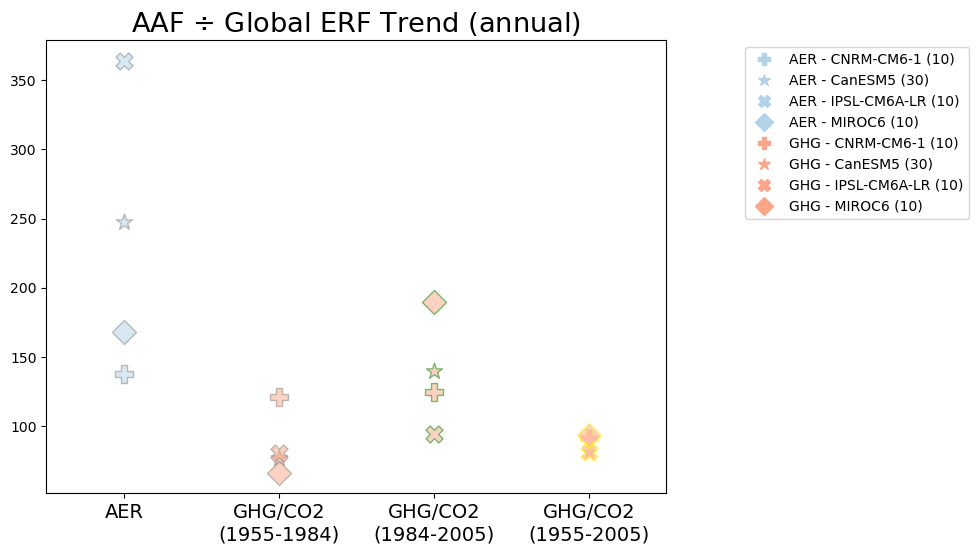

In [16]:
################################## figure 2 (supp.) ##################################
# plot 3 panels of scatter plot, each panel is for one variables
variable = [aaaf_damip]
variablec = [[aaaf_cesm1920], [aaaf_cesm1955], [aaaf_can1955]]
variable_name = ['AAF $\div$ Global ERF Trend (annual)']
variable_unit = ['']
variable_range = [[-0.5,0.5],[-0.5,0.5],[-0.5,0.5]]
fontsize = 14
color = [color_aer[0], color_ghg[0]]
colorc = [color_aer[1], color_ghg[1]]
markers = ['P', '*', 'X', "D"]
markersc = ['o', '^', 's']
num = [10,30,10,10]
numc = [20,10,20]
legend_name = [
        ['AER - CNRM-CM6-1', 'GHG - CNRM-CM6-1'],
        ['AER - CanESM5', 'GHG - CanESM5'],
        ['AER - IPSL-CM6A-LR', 'GHG - IPSL-CM6A-LR'],
        ['AER - MIROC6', 'GHG - MIROC6']
    ]

# add legend outside the plot
legend = []
for i in range(2):
    for j in range(4):
        legend.append(mlines.Line2D([], [], color = color[i], marker = markers[j], markersize=9, label='%s (%s)'%(legend_name[j][i], num[j]), linestyle = 'None'))

edgestyle = ['-', '-', '-']
edgecolor = ['grey', 'green', 'yellow']
fig = plt.figure(figsize=(8,6), dpi = 100)


erf_data = xr.open_dataarray('erf/erf_rfmip_all.nc').mean('month').sel(area = 'tropics')

erf_trend = [linear_trend(erf_data.sel(agent = 'hist-aer'), year_interval=[1955,1984]), linear_trend(erf_data.sel(agent = 'hist-GHG'), year_interval=[1955,1984]), linear_trend(erf_data.sel(agent = 'hist-GHG'), year_interval=[1985,2005]), linear_trend(erf_data.sel(agent = 'hist-GHG'), year_interval=[1955,2005])]


for i in range(1):
    ax = fig.add_subplot(1,1,i+1)
    for j in range(4): # model
        for k in range(2): # agent
            if k == 1:
                for l in range(3): # period
                    ax.scatter([k+l], (variable[i]['variable'].mean('rsp').sel(model = model_list[j], period = year_interval_str[l], agent = exp_list[k])/variable[i]['tas_global']).mean('rsp').sel(model = model_list[j], period = year_interval_str[l], agent = exp_list[k])/np.abs(erf_trend[l+1][j]), s = 150, color = color[k], alpha = 0.5, marker = markers[j], edgecolor=edgecolor[l], linestyle = edgestyle[l])
            else:
                ax.scatter([k], (variable[i]['variable'].mean('rsp').sel(model = model_list[j], period = year_interval_str[0], agent = exp_list[k])/variable[i]['tas_global']).mean('rsp').sel(model = model_list[j], period = year_interval_str[0], agent = exp_list[k])/np.abs(erf_trend[0][j]), s = 150, color = color[k], alpha = 0.5, marker = markers[j], edgecolor=edgecolor[0])

    # axis setting
    ax.set_xlim([-0.5,3.5])
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(['AER', 'GHG/CO2\n(1955-1984)', 'GHG/CO2\n(1984-2005)', 'GHG/CO2\n(1955-2005)',], fontsize = fontsize)
    ax.set_ylabel(variable_unit[i], fontsize = fontsize)
    ax.set_title(variable_name[i], fontsize = fontsize*1.4)
    # ax.set_ylim([1.4,5.])

    ax.legend(handles = legend,loc='upper right', bbox_to_anchor=(1.5, 1), fontsize = fontsize-4)


In [17]:
erf_trend[0]

<xarray.DataArray 'polyfit_coefficients' (model: 4)>
array([-0.02387492, -0.01770841, -0.0122032 , -0.01907002])
Coordinates:
    degree   int64 1
  * model    (model) object 'CNRM-CM6-1' 'CanESM5' 'IPSL-CM6A-LR' 'MIROC6'

/Users/youtingw/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/youtingw/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/youtingw/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-leve

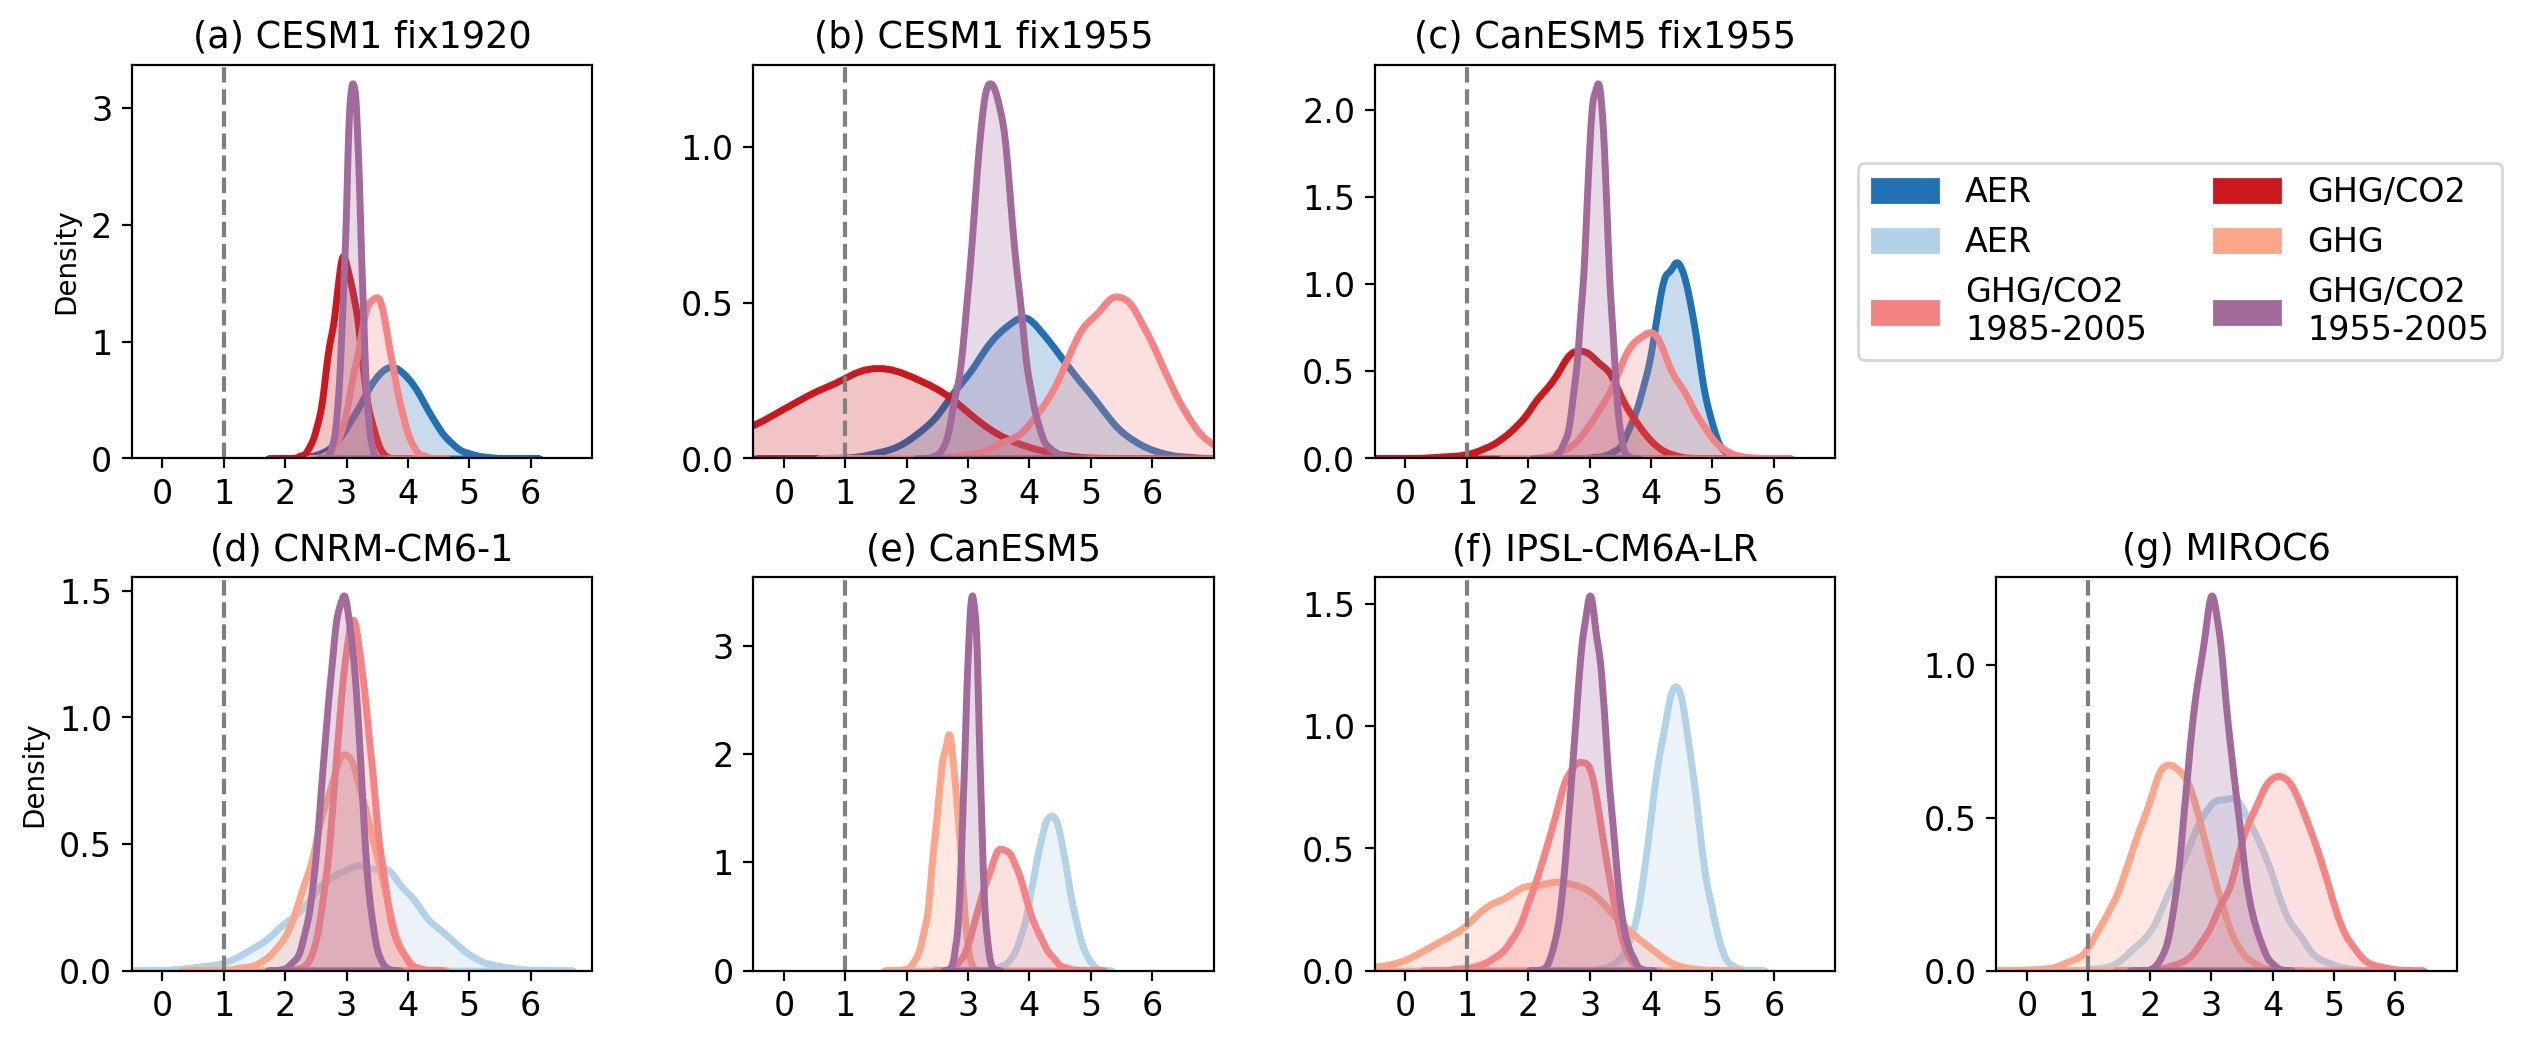

In [18]:
################################## figure 3 (supp.) ##################################
# calculate resampled AAF
raaf_damip = aaaf_damip['variable'] / aaaf_damip['tas_global']
raaf_cesm1955 = aaaf_cesm1955['variable'] / aaaf_cesm1955['tas_global']
raaf_can1955 = aaaf_can1955['variable'] / aaaf_can1955['tas_global']
raaf_cesm1920 = aaaf_cesm1920['variable'] / aaaf_cesm1920['tas_global']

aaf_plot = [raaf_cesm1920, raaf_cesm1955, raaf_can1955, raaf_damip]

fontsize = 12
xlim = [-0.5, 7]
color = [color_aer[0], color_ghg[0]]
colorc = [color_aer[1], color_ghg[1]]
markers = ['P', '*', 'X', "D"]
markersc = ['o', '^', 's']
num = [10,30,10,10]
numc = [20,10,20]
legend_name = [
        ['AER - CNRM-CM6-1', 'GHG - CNRM-CM6-1'],
        ['AER - CanESM5', 'GHG - CanESM5'],
        ['AER - IPSL-CM6A-LR', 'GHG - IPSL-CM6A-LR'],
        ['AER - MIROC6', 'GHG - MIROC6']
    ]
legend_namec = [
        ['AER - CESM1 fix1920', 'GHG - CESM1 fix1920'],
        ['AER - CESM1 fix1955', 'CO2 - CESM1 fix1955'],
        ['AER - CanESM5 fix1955', 'CO2 - CanESM5 fix1955']
    ]

color_name = [['AER','GHG/CO2'],['AER','GHG']]

# randomly create red color code
color_red = ['#F68383','#A26A9A']

# plot distribution using sns
fig, ax = plt.subplots(2, 4, figsize=(15, 6), dpi = 200)
fig.delaxes(ax[0, 3])

# more space between subplots
fig.subplots_adjust(hspace = 0.3, wspace=0.35)

for i in range(4):
    if i <3:
        for j in range(2): # agent
            sns.distplot(aaf_plot[i].sel(period = year_interval_str[0], agent = exp_list_cesm[j]), ax=ax[0, i], hist=False, kde=True, rug=False, kde_kws={"shade": True, 'linewidth': 2.5}, color=colorc[j])

            if j ==1:
                for k in range(2):
                    sns.distplot(aaf_plot[i].sel(period = year_interval_str[k+1], agent = exp_list_cesm[j]), ax=ax[0, i], hist=False, kde=True, rug=False, kde_kws={"shade": True, 'linewidth': 2.5}, color=color_red[k])


        ax[0,i].set_title(alph[i] +' '+legend_namec[i][0].split(' - ')[1], fontsize=fontsize*1.1)

    else:
        for j in range(2): # agent
            for k in range(4):
                sns.distplot(aaf_plot[i][k].sel(period = year_interval_str[0], agent = exp_list[j]), ax=ax[1, k], hist=False, kde=True, rug=False, kde_kws={"shade": True, 'linewidth': 2.5}, color=color[j])

                if j ==1:
                    for l in range(2):
                        sns.distplot(aaf_plot[i][k].sel(period = year_interval_str[l+1], agent = exp_list[j]), ax=ax[1, k], hist=False, kde=True, rug=False, kde_kws={"shade": True, 'linewidth': 2.5}, color=color_red[l])

                ax[1,k].set_title(alph[i+k] +' '+legend_name[k][0].split(' - ')[1], fontsize=fontsize*1.1)


for i in range(len(ax.flatten())):
    ax.flatten()[i].set_xlim(xlim)
    ax.flatten()[i].set_xticks(np.arange(0, 6+0.5, 1))
    ax.flatten()[i].set_xticklabels(np.arange(0, 6+0.5, 1).astype(int), fontsize=fontsize)
    ax.flatten()[i].axvline(x = 1, color='grey', ls='--', lw=1.5)
    ax.flatten()[i].tick_params(axis='both', which='major', labelsize=fontsize)

    if np.mod(i,4) != 0:
        # close y-label
        ax.flatten()[i].set_ylabel('')

# add legend
legend = []
y = ['GHG/CO2\n1985-2005', 'GHG/CO2\n1955-2005']
for j in range(2):
    legend.append(mpatches.Patch(color= colorc[j], label=color_name[0][j]))
    legend.append(mpatches.Patch(color= color[j], label=color_name[1][j]))
    legend.append(mpatches.Patch(color= color_red[j], label=y[j]))


ax[0,2].legend(handles = legend,loc='center', bbox_to_anchor=(1.75, 0.5), fontsize = fontsize, ncol = 2)



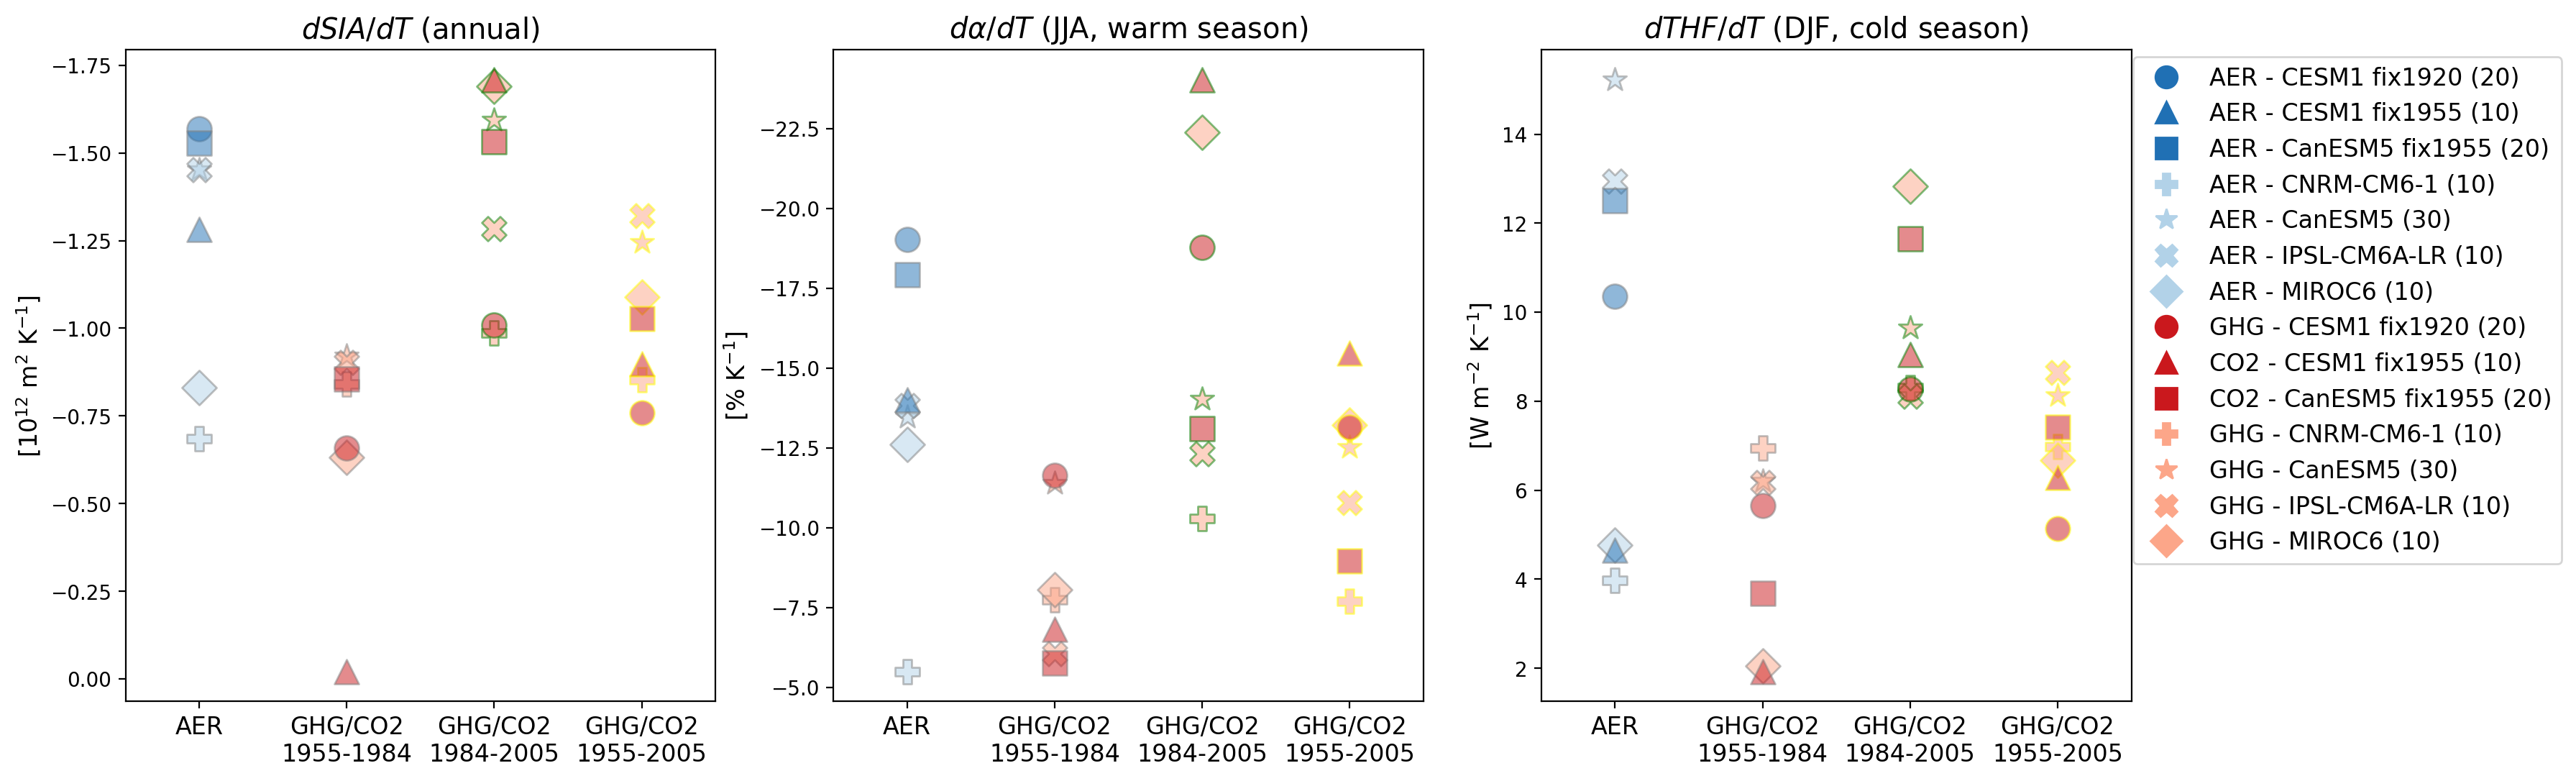

In [19]:
################################## figure 4 (supp.) ##################################
# plot 3 panels of scatter plot, each panel is for one variables
variable = [asia_damip, walb_damip, cthf_dmaip]
variablec = [[asia_cesm1920, walb_cesm1920, cthf_cesm1920], [asia_cesm1955, walb_cesm1955, cthf_cesm1955], [asia_can1955, walb_can1955, cthf_can1955]]
variable_name = ['$dSIA/dT$ (annual)',r'$d\alpha/dT$ (JJA, warm season)','$dTHF/dT$ (DJF, cold season)']
variable_unit = ['[10$^{12}$ m$^2$ K$^{-1}$]','[% K$^{-1}$]','[W m$^{-2}$ K$^{-1}$]']
variable_range = [[-0.5,0.5],[-0.5,0.5],[-0.5,0.5]]
fontsize = 12
color = [color_aer[0], color_ghg[0]]
colorc = [color_aer[1], color_ghg[1]]
markers = ['P', '*', 'X', "D"]
markersc = ['o', '^', 's']
num = [10,30,10,10]
numc = [20,10,20]
legend_name = [
        ['AER - CNRM-CM6-1', 'GHG - CNRM-CM6-1'],
        ['AER - CanESM5', 'GHG - CanESM5'],
        ['AER - IPSL-CM6A-LR', 'GHG - IPSL-CM6A-LR'],
        ['AER - MIROC6', 'GHG - MIROC6']
    ]
legend_namec = [
        ['AER - CESM1 fix1920', 'GHG - CESM1 fix1920'],
        ['AER - CESM1 fix1955', 'CO2 - CESM1 fix1955'],
        ['AER - CanESM5 fix1955', 'CO2 - CanESM5 fix1955']
    ]

# add legend outside the plot

legend = []
for i in range(2):
    for j in range(3):
        legend.append(mlines.Line2D([], [], color = colorc[i], marker = markersc[j], markersize=11, label='%s (%s)'%(legend_namec[j][i], numc[j]), linestyle = 'None'))
    for j in range(4):
        legend.append(mlines.Line2D([], [], color = color[i], marker = markers[j], markersize=11, label='%s (%s)'%(legend_name[j][i], num[j]), linestyle = 'None'))

edgestyle = ['-', '-', '-']
edgecolor = ['grey', 'green', 'yellow']
fig = plt.figure(figsize=(18,6), dpi = 200)
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    for j in range(7): # model
        if j <4:
            for k in range(2): # agent
                if k == 1:
                    for l in range(3):
                        ax.scatter([k+l], (variable[i]['variable'].mean('rsp').sel(model = model_list[j], period = year_interval_str[l], agent = exp_list[k])/variable[i]['tas_global']).mean('rsp').sel(model = model_list[j], period = year_interval_str[l], agent = exp_list[k]), s = 150, color = color[k], alpha = 0.5, marker = markers[j], edgecolor=edgecolor[l], linestyle = edgestyle[l])
                else:
                    ax.scatter([k], (variable[i]['variable'].mean('rsp').sel(model = model_list[j], period = year_interval_str[0], agent = exp_list[k])/variable[i]['tas_global']).mean('rsp').sel(model = model_list[j], period = year_interval_str[0], agent = exp_list[k]), s = 150, color = color[k], alpha = 0.5, marker = markers[j], edgecolor='grey')

        else:
            for k in range(2): # agent
                if k == 1:
                    for l in range(3):
                        ax.scatter([k+l], (variablec[j-4][i]['variable'].mean('rsp').sel(period = year_interval_str[l], agent = exp_list_cesm[k])/variablec[j-4][i]['tas_global']).mean('rsp').sel(period = year_interval_str[l], agent = exp_list_cesm[k]), s = 150, color = colorc[k], alpha = 0.5, marker = markersc[j-4], edgecolor=edgecolor[l], linestyle = edgestyle[l])
                else:        
                    ax.scatter([k], (variablec[j-4][i]['variable'].mean('rsp').sel(period = year_interval_str[0], agent = exp_list_cesm[k])/variablec[j-4][i]['tas_global']).mean('rsp').sel(period = year_interval_str[0], agent = exp_list_cesm[k]), s = 150, color = colorc[k], alpha = 0.5, marker = markersc[j-4], edgecolor='grey')


    # axis setting
    ax.set_xlim([-0.5,3.5])
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(['AER', 'GHG/CO2\n1955-1984', 'GHG/CO2\n1984-2005', 'GHG/CO2\n1955-2005',], fontsize = fontsize)
    ax.set_ylabel(variable_unit[i], fontsize = fontsize)
    ax.set_title(variable_name[i], fontsize = fontsize*1.2)
    # filp the y-axis
    if i == 0 or i==1:
        ax.invert_yaxis()
    else:
        ax.legend(handles = legend,loc='right', bbox_to_anchor=(1.75, 0.6), fontsize = fontsize)


In [20]:
# plot 4 panels, 1x4 use scatter plot, with 4 panels, each panel is for one variables
def seasonal_sensitivity_plot(variable, model):
    month_2d = np.reshape(np.tile(np.arange(1,13),N), (N,12))
    var_name = ['$dSIA/dT$',r'$d\alpha/dT$','$dTHF/dT$','AAF']
    fontsize = 14
    markers = ['P', '*', 'X', "D"]

    if model == 'CESM1-fix1955' or model == 'CanESM5-fix1955' or model == 'CESM1-fix1920':
        color = [color_aer[1], color_ghg[1]]
        exp = exp_list_cesm
    else:
        color = [color_aer[0], color_ghg[0]]
        exp = exp_list

    # duplicate the month dimension
    month = np.tile(np.arange(12), 2)
    fig, axs = plt.subplots(1, 4, figsize=(16, 8),sharey=True)
    for var in range(4):
        for agent in range(2):
            # axs[var].scatter((variable[var]['variable']/variable[var]['tas_global']).sel(period=year_interval_str[0], agent=exp[agent]),month_2d, c=color[agent], s=1, alpha=0.1)
            
            axs[var].scatter((variable[var]['variable'].mean('rsp')/variable[var]['tas_global'].mean('rsp')).sel(period='1955', agent=exp[agent]), month_2d.mean(0), c=color[agent], s=50, alpha=1)
            
            axs[var].set_title(var_name[var], fontsize = fontsize*1.2)


        
    # axis setting
    axs[0].set_ylabel('Month', fontsize = fontsize)
    axs[0].set_yticks(np.arange(1,13,1))
    axs[0].set_yticklabels(month_abbr)
    axs[3].set_xlim(-0.5,10.5)

    # axs[0].set_xlim(-7,7)
    # axs[1].set_xlim(-35,5)
    # axs[2].set_xlim(-30,20)


    # revers y-axis
    # axs[0].invert_xaxis()
    # axs[1].invert_xaxis()
    # axs[2].invert_xaxis()


    # add big title for model name
    fig.suptitle(model, fontsize=fontsize*1.5)
    for var in range(4):
        axs[var].axvline(0, color='k', linestyle = '--', linewidth=0.5, alpha=0.5)
        # font size
        axs[var].tick_params(axis='both', which='major', labelsize=fontsize)

        # save figure
    fig.savefig('figure/fig4_'+model+'.jpg', dpi=300, bbox_inches='tight')

# for i in range(4):
#     variable = [msia_damip.isel(model = i), malb_dmaip.isel(model = i), mthf_damip.isel(model = i), maaf_damip.isel(model = i)]
#     seasonal_sensitivity_plot(variable, model_list[i])

# variable = [msia_cesm1955, malb_cesm1955, mthf_cesm1955, maaf_cesm1955]
# seasonal_sensitivity_plot(variable, 'CESM1-fix1955')
# variable = [msia_can1955, malb_can1955, mthf_can1955, maaf_can1955]
# seasonal_sensitivity_plot(variable, 'CanESM5-fix1955')
# variable = [msia_cesm1920, malb_cesm1920, mthf_cesm1920, maaf_cesm1920]
# seasonal_sensitivity_plot(variable, 'CESM1-fix1920')


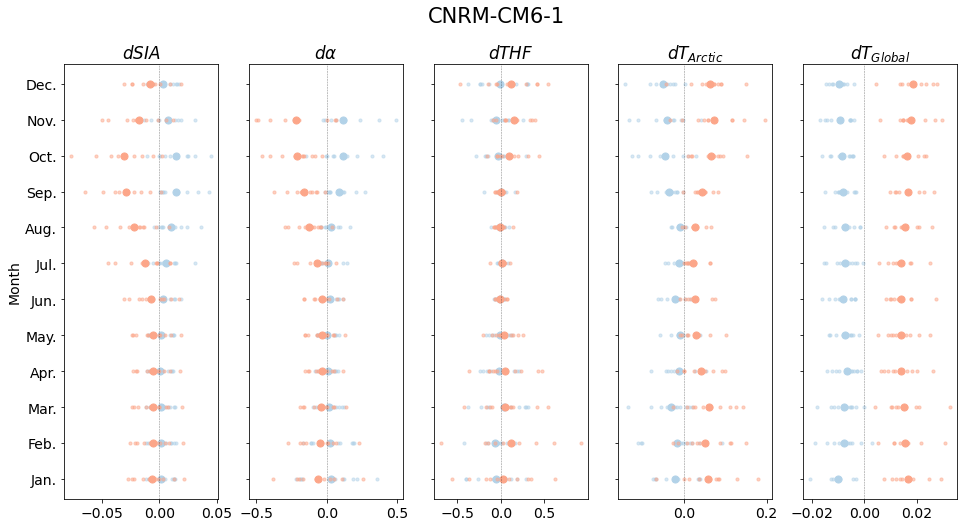

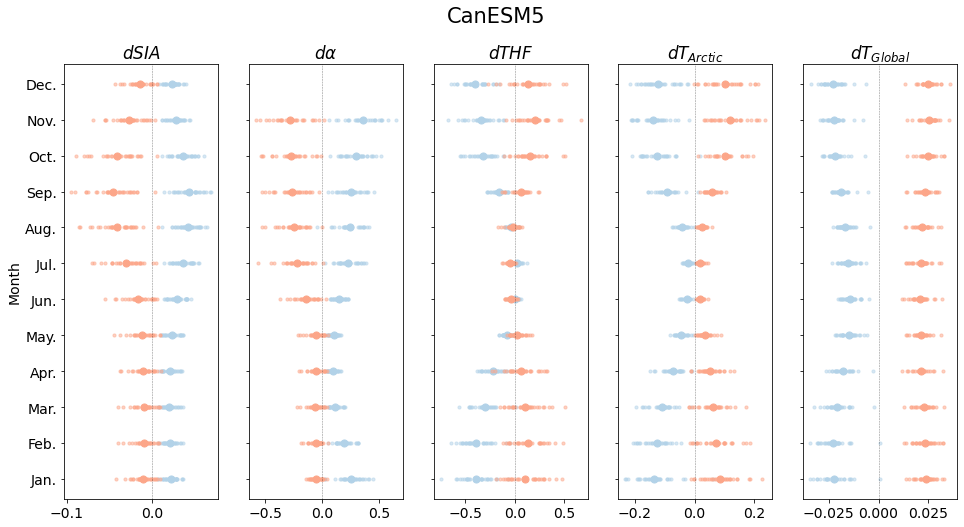

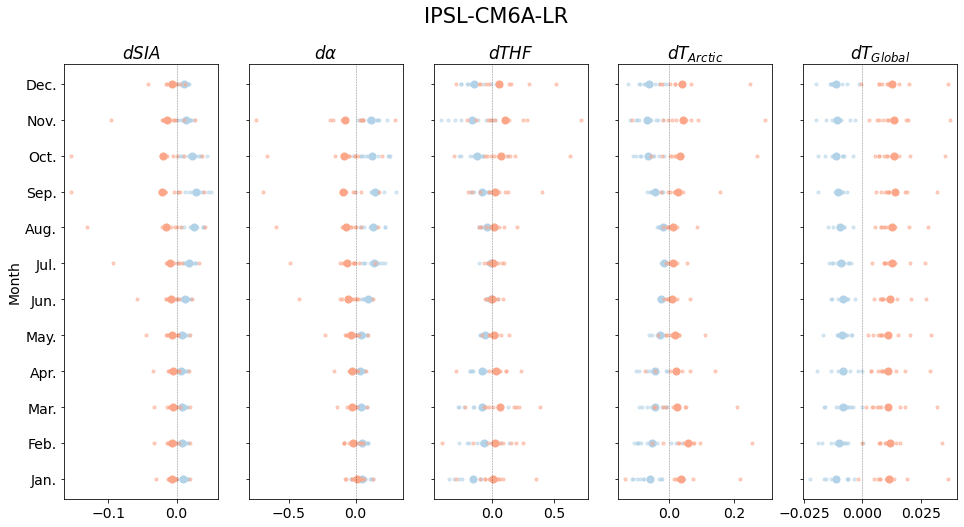

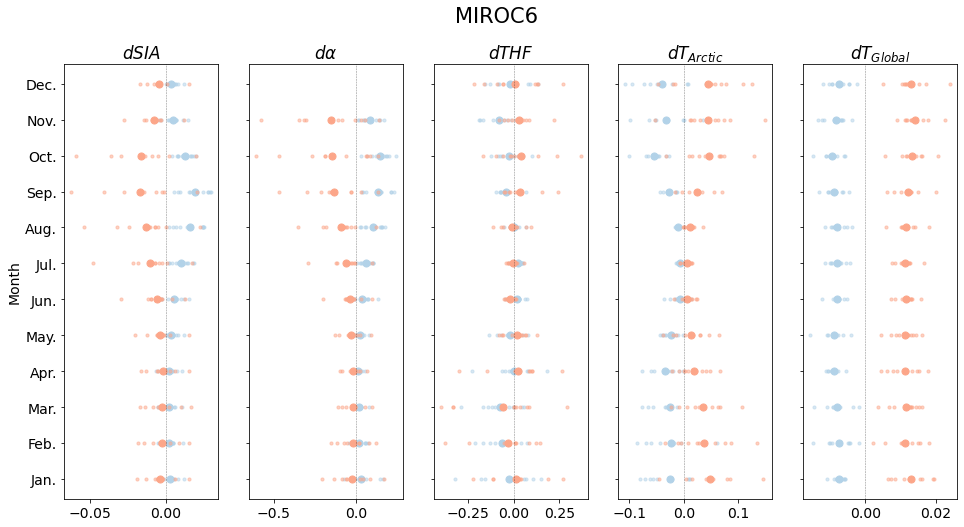

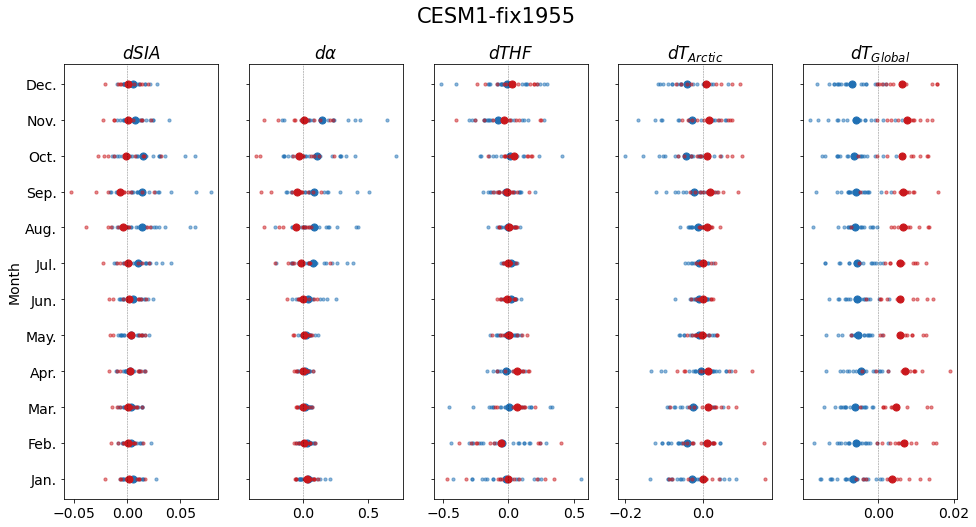

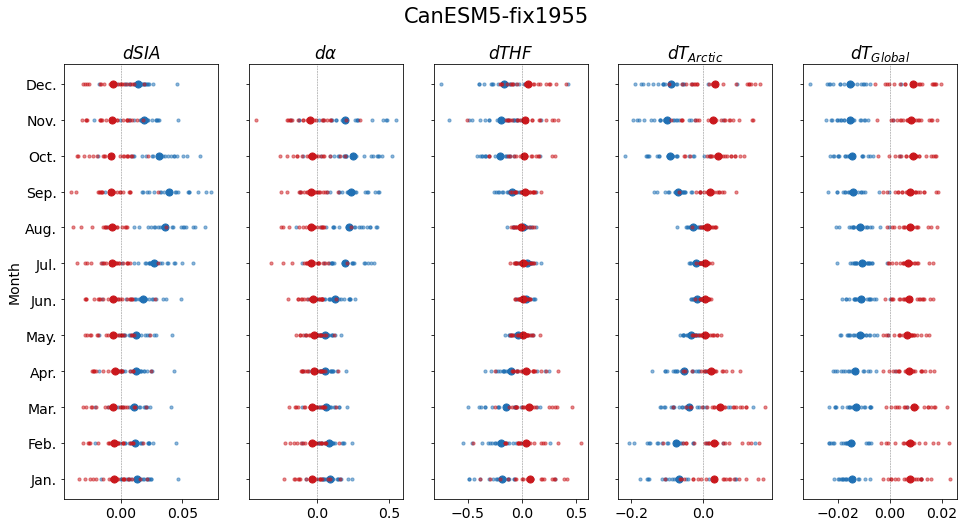

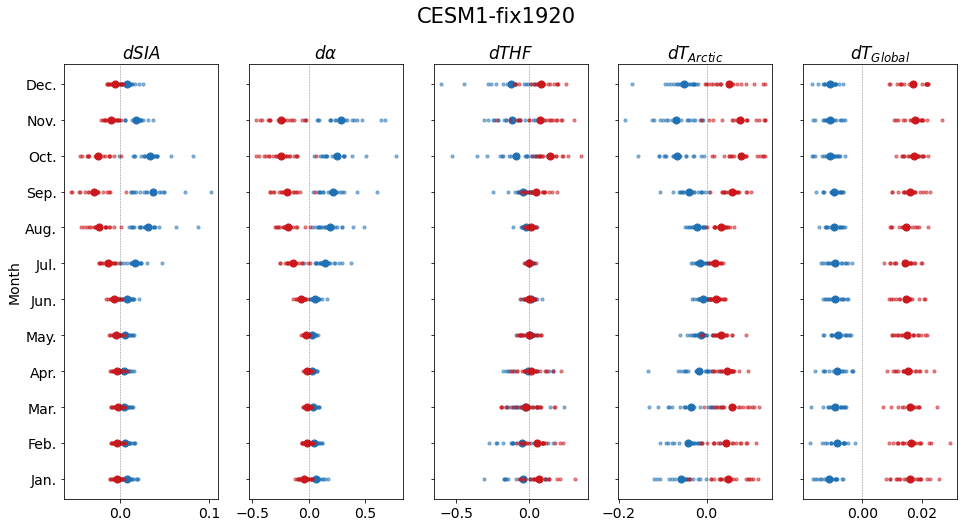

In [21]:
def seasonal_plot(variable, model):
    N = variable[0].shape[0]
    month_2d = np.reshape(np.tile(np.arange(1,13),N), (N,12))
    var_name = ['$dSIA$',r'$d\alpha$','$dTHF$','$dT_{Arctic}$','$dT_{Global}$']
    fontsize = 14

    if model == 'CESM1-fix1955' or model == 'CanESM5-fix1955' or model == 'CESM1-fix1920':
        color = [color_aer[1], color_ghg[1]]
        exp = exp_list_cesm
    else:
        color = [color_aer[0], color_ghg[0]]
        exp = exp_list

    # duplicate the month dimension
    fig, axs = plt.subplots(1, 5, figsize=(16, 8),sharey=True)
    for var in range(5):
        for agent in range(2):
            axs[var].scatter(variable[var].sel(period='1955', agent=exp[agent]),month_2d, color=color[agent], s=10, alpha=0.5)
            
            axs[var].scatter(variable[var].mean('ensemble').sel(period='1955', agent=exp[agent]), month_2d.mean(0), color=color[agent], s=50, alpha=1)
            
            axs[var].set_title(var_name[var], fontsize = fontsize*1.2)


        
    # axis setting
    axs[0].set_ylabel('Month', fontsize = fontsize)
    axs[0].set_yticks(np.arange(1,13,1))
    axs[0].set_yticklabels(month_abbr)
    # axs[3].set_xlim(-0.5,10.5)

    # add big title for model name
    fig.suptitle(model, fontsize=fontsize*1.5)
    for var in range(5):
        axs[var].axvline(0, color='k', linestyle = '--', linewidth=0.5, alpha=0.5)
        # font size
        axs[var].tick_params(axis='both', which='major', labelsize=fontsize)

        # save figure
    fig.savefig('figure/seasaoal_'+model+'.jpg', dpi=300, bbox_inches='tight')

for i in range(4):
    variable = [sia_month_damip[i], alb_month_damip[i], thf_month_damip[i], ta_month_damip[i], tg_month_damip[i]]
    seasonal_plot(variable, model_list[i])

variable = [sia_month_cesm1955, alb_month_cesm1955, thf_month_cesm1955, ta_month_cesm1955, tg_month_cesm1955]
seasonal_plot(variable, 'CESM1-fix1955')
variable = [sia_month_can1955, alb_month_can1955, thf_month_can1955, ta_month_can1955, tg_month_can1955]
seasonal_plot(variable, 'CanESM5-fix1955')
variable = [sia_month_cesm1920, alb_month_cesm1920, thf_month_cesm1920, ta_month_cesm1920, tg_month_cesm1920]
seasonal_plot(variable, 'CESM1-fix1920')
